In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from typing import Tuple
from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb

In [55]:
pd.set_option('display.max_columns', None)

In [56]:
data_path = Path("../data")

In [57]:
df_final = pd.read_parquet(data_path / "full_data.parquet")

reordenar las columnas para visualizar de forma mas intuitiva.  

In [58]:
column_order = [
    'advertiser_zrive_id',
    'period_int',
    'monthly_published_ads',
    'monthly_published_ads_3_months_mean',
    'monthly_published_ads_3_months_mean_delta',
    'monthly_unique_published_ads',
    'monthly_contracted_ads',
    'monthly_contracted_ads_3_months_mean',
    'monthly_contracted_ads_3_months_mean_delta',
    'monthly_leads',
    'monthly_leads_3_months_mean',
    'monthly_leads_3_months_mean_delta',
    'monthly_visits',
    'monthly_visits_3_months_mean',
    'monthly_visits_3_months_mean_delta',
    'monthly_oro_ads',
    'monthly_plata_ads',
    'monthly_destacados_ads',
    'monthly_pepitas_ads',
    'monthly_shows',
    'monthly_total_phone_views',
    'monthly_total_calls',
    'monthly_total_emails',
    'monthly_total_invoice',
    'monthly_total_invoice_3_months_mean',
    'monthly_total_invoice_3_months_mean_delta',
    'monthly_unique_calls',
    'monthly_unique_emails',
    'monthly_unique_leads',
    'monthly_avg_ad_price',
    'monthly_avg_ad_price_3_months_mean',
    'monthly_avg_ad_price_3_months_mean_delta',
    'monthly_distinct_ads',
    'month_period',
    'tenure',
    'months_since_last_contract',
    'has_renewed',
    'monthly_total_premium_ads',
    'ratio_published_contracted',
    'ratio_published_contracted_3_months_mean',
    'ratio_published_contracted_3_months_mean_delta',
    'ratio_unique_published',
    'ratio_unique_published_3_months_mean',
    'ratio_unique_published_3_months_mean_delta',
    'ratio_premium_ads',
    'ratio_premium_ads_3_months_mean',
    'ratio_premium_ads_3_months_mean_delta',
    'leads_per_published_ad',
    'leads_per_published_ad_3_months_mean',
    'leads_per_published_ad_3_months_mean_delta',
    'leads_per_premium_ad',
    'leads_per_premium_ad_3_months_mean',
    'leads_per_premium_ad_3_months_mean_delta',
    'visits_per_published_ad',
    'visits_per_published_ad_3_months_mean',
    'visits_per_published_ad_3_months_mean_delta',
    'leads_per_visit',
    'leads_per_visit_3_months_mean',
    'leads_per_visit_3_months_mean_delta',
    'leads_per_shows',
    'leads_per_shows_3_months_mean',
    'leads_per_shows_3_months_mean_delta',
    'invoice_per_published_ad',
    'invoice_per_published_ad_3_months_mean',
    'invoice_per_published_ad_3_months_mean_delta',
    'invoice_per_lead',
    'invoice_per_lead_3_months_mean',
    'invoice_per_lead_3_months_mean_delta',
    'churn'
]

df_final = df_final[column_order]
df_final['churn'] = df_final['churn'].astype(int)

In [59]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56335 entries, 0 to 56334
Data columns (total 69 columns):
 #   Column                                          Non-Null Count  Dtype    
---  ------                                          --------------  -----    
 0   advertiser_zrive_id                             56335 non-null  int64    
 1   period_int                                      56335 non-null  int64    
 2   monthly_published_ads                           56335 non-null  int64    
 3   monthly_published_ads_3_months_mean             56335 non-null  float64  
 4   monthly_published_ads_3_months_mean_delta       56335 non-null  float64  
 5   monthly_unique_published_ads                    56335 non-null  int64    
 6   monthly_contracted_ads                          56335 non-null  int64    
 7   monthly_contracted_ads_3_months_mean            56335 non-null  float64  
 8   monthly_contracted_ads_3_months_mean_delta      56335 non-null  float64  
 9   monthly_leads         

Problemas con nulls:

* monthly_avg_ad_price (y posteriormente monthly_avg_ad_price_3_months_mean, monthly_avg_ad_price_3_months_mean_delta)

* monthly_distint_ads

Existe un patron, cuando hay NaN en monthly_avg_ad_price, suele haber NaN en monthly_distint_ads.

Además siempre ocurre en los primeros meses de cada usuario ¿motivo?


In [60]:
nulls_df_final = df_final[['advertiser_zrive_id', 'period_int', 'monthly_published_ads',
         'monthly_contracted_ads','monthly_avg_ad_price', 'monthly_distinct_ads', 'churn']]

In [61]:
nulls_df_final[nulls_df_final['advertiser_zrive_id'] == 1]

,advertiser_zrive_id,period_int,monthly_published_ads,monthly_contracted_ads,monthly_avg_ad_price,monthly_distinct_ads,churn
0,1,202301,47,75,NaN,NaN,0
3302,1,202302,44,50,NaN,NaN,1


In [62]:
nulls_df_final[nulls_df_final['advertiser_zrive_id'] == 2]

,advertiser_zrive_id,period_int,monthly_published_ads,monthly_contracted_ads,monthly_avg_ad_price,monthly_distinct_ads,churn
1,2,202301,31,150,NaN,NaN,0
3303,2,202302,31,150,NaN,NaN,0
6312,2,202303,47,150,NaN,NaN,0
9162,2,202304,64,150,NaN,NaN,0
11878,2,202305,79,150,NaN,1.0,0
14493,2,202306,76,150,15990.00,1.0,0
17035,2,202307,71,150,19740.00,2.0,0
19502,2,202308,78,150,19990.00,5.0,0
21877,2,202309,72,150,19990.00,8.0,0
24156,2,202310,84,150,22247.62,31.0,0


In [63]:
nulls_df_final[nulls_df_final['advertiser_zrive_id'] == 3]

,advertiser_zrive_id,period_int,monthly_published_ads,monthly_contracted_ads,monthly_avg_ad_price,monthly_distinct_ads,churn
39613,3,202405,17,35,42864.59,17.0,0
41768,3,202406,17,35,42864.59,17.0,1


In [64]:
nulls_df_final[nulls_df_final['advertiser_zrive_id'] == 4]

,advertiser_zrive_id,period_int,monthly_published_ads,monthly_contracted_ads,monthly_avg_ad_price,monthly_distinct_ads,churn
2,4,202301,79,85,NaN,NaN,0
3304,4,202302,85,85,NaN,NaN,0
6313,4,202303,112,160,NaN,NaN,0
9163,4,202304,127,160,NaN,NaN,0
11879,4,202305,134,100,22900.00,33.0,0
14494,4,202306,142,100,22570.27,38.0,0
17036,4,202307,131,100,22535.00,40.0,0
19503,4,202308,100,100,22555.81,41.0,0
21878,4,202309,100,100,22426.09,39.0,0
24157,4,202310,100,100,23068.00,42.0,0


In [65]:
nulls_df_final[nulls_df_final['advertiser_zrive_id'] == 5]

,advertiser_zrive_id,period_int,monthly_published_ads,monthly_contracted_ads,monthly_avg_ad_price,monthly_distinct_ads,churn
43957,5,202407,0,100,NaN,NaN,0
46115,5,202408,100,100,25662.30,145.0,0
48236,5,202409,100,100,25578.39,207.0,0
50265,5,202410,92,100,25605.76,184.0,1


In [66]:
nulls_df_final[nulls_df_final['advertiser_zrive_id'] == 6]

,advertiser_zrive_id,period_int,monthly_published_ads,monthly_contracted_ads,monthly_avg_ad_price,monthly_distinct_ads,churn
3,6,202301,20,20,NaN,NaN,0
3305,6,202302,20,20,NaN,NaN,0
6314,6,202303,20,20,NaN,NaN,0
9164,6,202304,17,20,NaN,NaN,0
11880,6,202305,20,20,NaN,NaN,0
14495,6,202306,20,20,NaN,NaN,0
17037,6,202307,20,20,NaN,NaN,0
19504,6,202308,20,20,NaN,NaN,0
21879,6,202309,23,20,NaN,NaN,0
24158,6,202310,29,20,54999.00,1.0,0


* monthly_distint_ads es " número total de anuncios diferentes publicados en un mes, rotación total durante un mes" . Parece que hay un patron, que va aumentando conforme pasan los meses, tiene sentido que los NaN realmente sean 0's. 

In [67]:
#para monthly_distint_ads
df_final['monthly_distinct_ads'] = df_final['monthly_distinct_ads'].fillna(0)

"monthly_avg_ad_price" lo que mas sentido tiene es eliminarla, ya que la forma de imputarla pensada depende del futuro, lo cual no sabemos, no podemos hacer nada con ella

monthly_distinct_ads la he eliminado tambien ya que me da mucha importance comparada con el resto, sospecho que puede haber data leakage

In [68]:
#elimino monthly_avg_ad_price_3_months_mean, monthly_avg_ad_price_3_months_mean_delta , ya que habria que recalcularlas con los valores nuevos
df_final = df_final.drop(['monthly_distinct_ads', 'monthly_avg_ad_price', 'monthly_avg_ad_price_3_months_mean', 'monthly_avg_ad_price_3_months_mean_delta' ], axis=1)

In [ ]:
# 1. Encontrar los IDs con al menos un NaN en alguna de las dos columnas
ids_with_nan = df_final[
    df_final['tenure'].isna() | df_final['months_since_last_contract'].isna()
]['advertiser_zrive_id'].unique()

# 2. Eliminar todas las filas que tengan esos IDs
df_final = df_final[~df_final['advertiser_zrive_id'].isin(ids_with_nan)]

# Train models

Primero entrenar un modelo con un periodo, para justificar que modelos no lineales mejoran modelos lineales

Despues entrenar modelo no lineal por cada periodo y ver metricas

In [69]:
df_final.head()

,advertiser_zrive_id,period_int,monthly_published_ads,monthly_published_ads_3_months_mean,monthly_published_ads_3_months_mean_delta,monthly_unique_published_ads,monthly_contracted_ads,monthly_contracted_ads_3_months_mean,monthly_contracted_ads_3_months_mean_delta,monthly_leads,monthly_leads_3_months_mean,monthly_leads_3_months_mean_delta,monthly_visits,monthly_visits_3_months_mean,monthly_visits_3_months_mean_delta,monthly_oro_ads,monthly_plata_ads,monthly_destacados_ads,monthly_pepitas_ads,monthly_shows,monthly_total_phone_views,monthly_total_calls,monthly_total_emails,monthly_total_invoice,monthly_total_invoice_3_months_mean,monthly_total_invoice_3_months_mean_delta,monthly_unique_calls,monthly_unique_emails,monthly_unique_leads,month_period,tenure,months_since_last_contract,has_renewed,monthly_total_premium_ads,ratio_published_contracted,ratio_published_contracted_3_months_mean,ratio_published_contracted_3_months_mean_delta,ratio_unique_published,ratio_unique_published_3_months_mean,ratio_unique_published_3_months_mean_delta,ratio_premium_ads,ratio_premium_ads_3_months_mean,ratio_premium_ads_3_months_mean_delta,leads_per_published_ad,leads_per_published_ad_3_months_mean,leads_per_published_ad_3_months_mean_delta,leads_per_premium_ad,leads_per_premium_ad_3_months_mean,leads_per_premium_ad_3_months_mean_delta,visits_per_published_ad,visits_per_published_ad_3_months_mean,visits_per_published_ad_3_months_mean_delta,leads_per_visit,leads_per_visit_3_months_mean,leads_per_visit_3_months_mean_delta,leads_per_shows,leads_per_shows_3_months_mean,leads_per_shows_3_months_mean_delta,invoice_per_published_ad,invoice_per_published_ad_3_months_mean,invoice_per_published_ad_3_months_mean_delta,invoice_per_lead,invoice_per_lead_3_months_mean,invoice_per_lead_3_months_mean_delta,churn
0,1,202301,47,47.000000,0.000000,47,75,75.0,0.0,18,18.000000,0.000000,40890.0,40890.0,0.0,6,6,6,0,2051941.5,14,15,0,440.8,440.800000,0.000000,12,3,15,2023-01,25.0,25.0,0,18,0.626667,0.626667,0.000000,1.0,1.0,0.0,0.382979,0.382979,0.000000,0.382979,0.382979,0.000000,1.000000,1.000000,0.000000,870.000000,870.000000,0.000000,0.000440,0.000440,0.000000,0.000009,0.000009,0.000000e+00,9.378723,9.378723,0.000000,24.488889,24.488889,0.000000,0
3302,1,202302,44,45.500000,-1.500000,44,50,62.5,-12.5,10,14.000000,-4.000000,34740.0,37815.0,-3075.0,3,3,1,0,1761028.5,18,6,3,464.8,452.800000,12.000000,5,4,9,2023-02,26.0,26.0,0,7,0.880000,0.753333,0.126667,1.0,1.0,0.0,0.159091,0.271035,-0.111944,0.227273,0.305126,-0.077853,1.428571,1.214286,0.214286,789.545455,829.772727,-40.227273,0.000288,0.000364,-0.000076,0.000006,0.000007,-1.546840e-06,10.563636,9.971180,0.592456,46.480000,35.484444,10.995556,1
1,2,202301,31,31.000000,0.000000,31,150,150.0,0.0,4,4.000000,0.000000,17970.0,17970.0,0.0,10,10,4,0,1250403.0,16,2,2,75.4,75.400000,0.000000,2,2,4,2023-01,28.0,28.0,1,24,0.206667,0.206667,0.000000,1.0,1.0,0.0,0.774194,0.774194,0.000000,0.129032,0.129032,0.000000,0.166667,0.166667,0.000000,579.677419,579.677419,0.000000,0.000223,0.000223,0.000000,0.000003,0.000003,0.000000e+00,2.432258,2.432258,0.000000,18.850000,18.850000,0.000000,0
3303,2,202302,31,31.000000,0.000000,31,150,150.0,0.0,4,4.000000,0.000000,10695.0,14332.5,-3637.5,10,10,4,0,1026553.5,10,2,1,54.9,65.150000,-10.250000,2,2,4,2023-02,29.0,29.0,1,24,0.206667,0.206667,0.000000,1.0,1.0,0.0,0.774194,0.774194,0.000000,0.129032,0.129032,0.000000,0.166667,0.166667,0.000000,345.000000,462.338710,-117.338710,0.000374,0.000298,0.000076,0.000004,0.000004,3.487824e-07,1.770968,2.101613,-0.330645,13.725000,16.287500,-2.562500,0
6312,2,202303,47,36.333333,10.666667,47,150,150.0,0.0,6,4.666667,1.333333,7845.0,12170.0,-4325.0,10,10,4,0,688947.0,16,5,1,34.3,54.866667,-20.566667,4,1,5,2023-03,30.0,30.0,1,24,0.313333,0.242222,0.071111,1.0,1.0,0.0,0.510638,0.686342,-0.175704,0.127660,0.128575,-0.000915,0.250000,0.194444,0.055556,166.914894,363.864104,-196.949211,0.000765,0.000454,0.000311,0.000009,0.000005,3.440795e-06,0.729787,1.644338,-0.9

In [70]:
info_cols = ['advertiser_zrive_id', 'period_int', 'month_period']
label_col = 'churn'
features_cols = [col for col in df_final.columns if col not in info_cols + [label_col]]


binary_cols = ['has_renewed']
numerical_cols = [col for col in features_cols if col not in  binary_cols]

In [ ]:
train_df = df_final[
    (df_final['month_period'] >= '202307') &
    (df_final['month_period'] < '202402')
]

val_df = df_final[df_final['month_period'] == '202402']

In [73]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        figure: Tuple[matplotlib.figure.Figure, np.array] = None
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure
        
        
    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC curve")
    ax[1].legend()

In [74]:
def feature_label_split(df: pd.DataFrame, label_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)

In [ ]:
train_cols = numerical_cols + binary_cols

# Ridge Regression

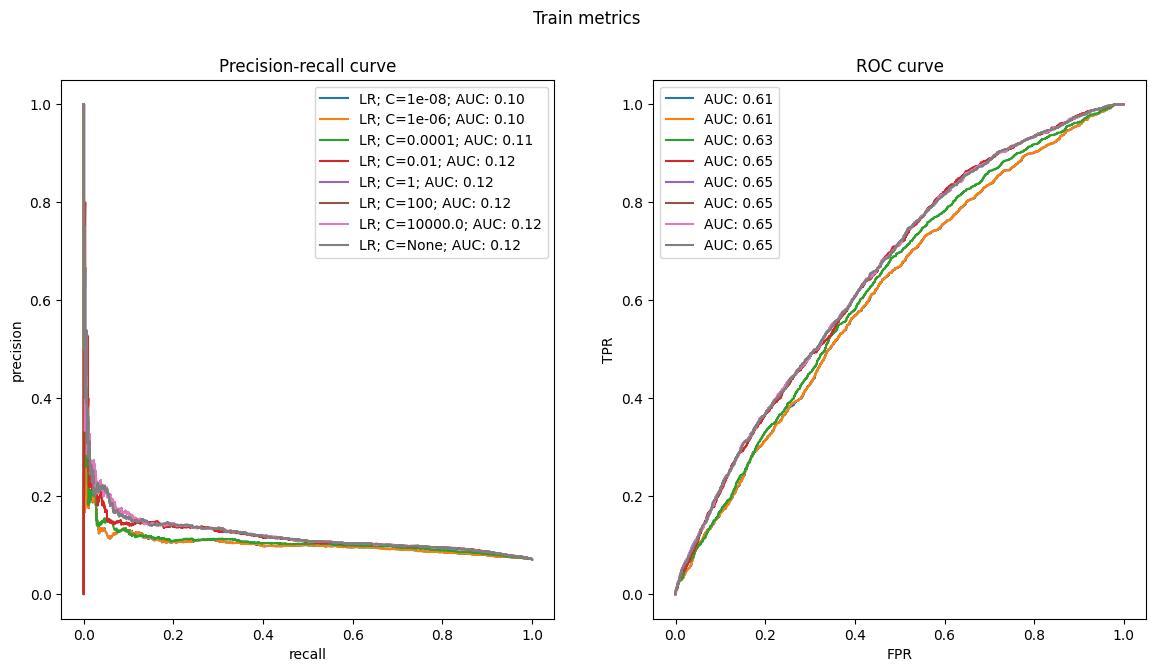

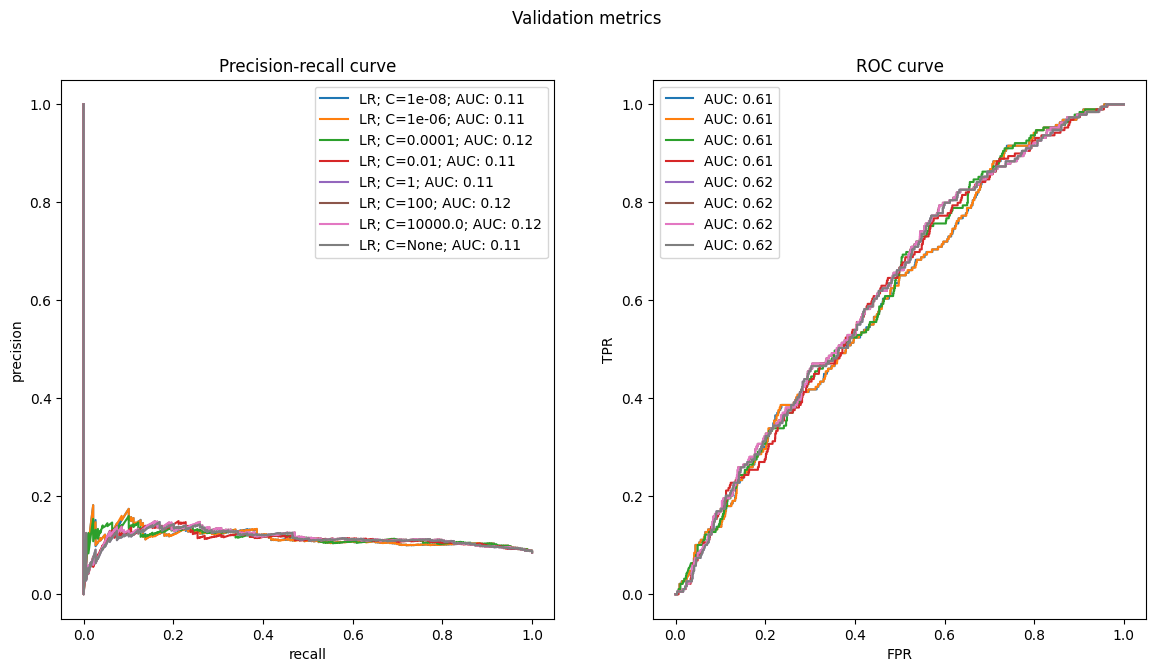

In [76]:
#usar pipelines porque une todos los pasos que forman parte del proceso de entrenamiento

lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []


fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None] #1/alpha
for c in cs:
    lr = make_pipeline(
    StandardScaler(),   #standard escaler necesita .fit para calcular media y desviacion estandar
    LogisticRegression(penalty="l2", C=c if c else 1.0),
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:,1]
    plot_metrics(
        f"LR; C={c}", y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
    )



Train Log Loss values: [0.2557118895297069, 0.2556608846708258, 0.25308232699279204, 0.24640111304294263, 0.24583635033327905, 0.24580779524285093, 0.24580803152223668, 0.24583635033327905]
Validation Log Loss values: [0.2933999286128151, 0.2933319389919602, 0.290347889304583, 0.2870487628556652, 0.28756209040815867, 0.28733297296976545, 0.28732888175263016, 0.28756209040815867]


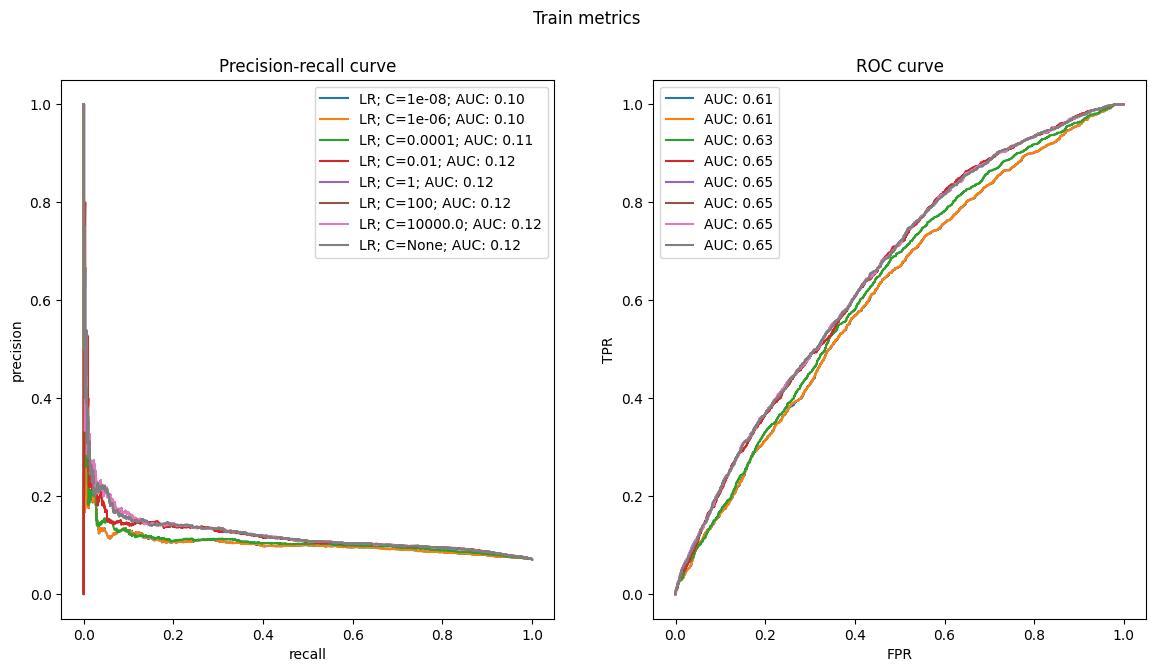

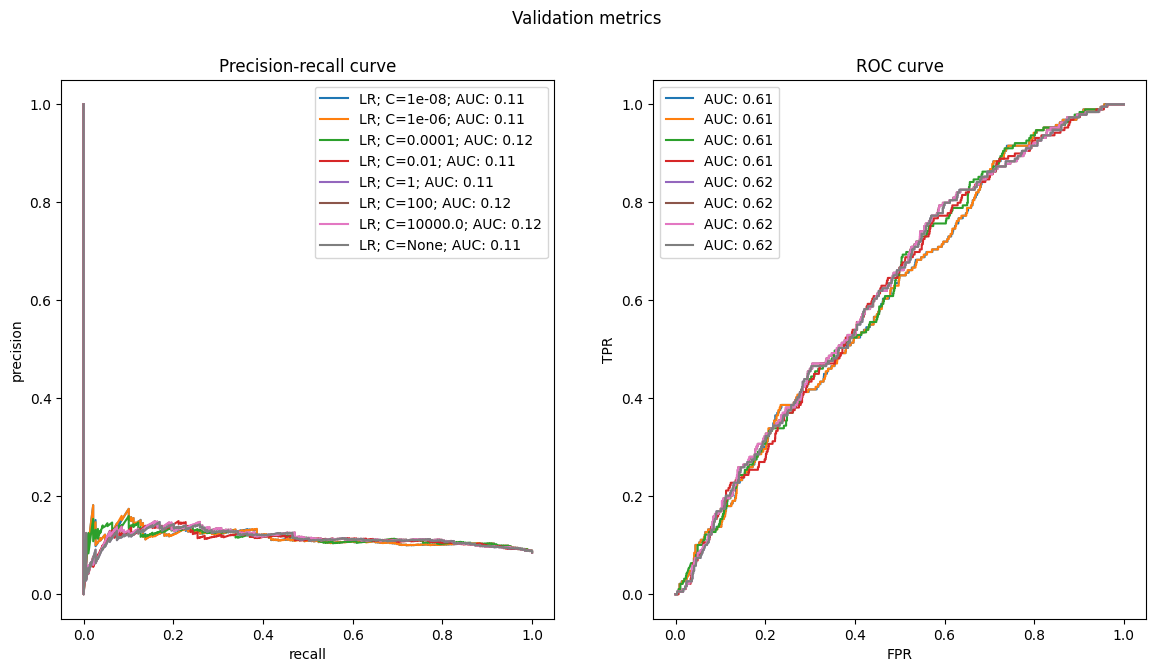

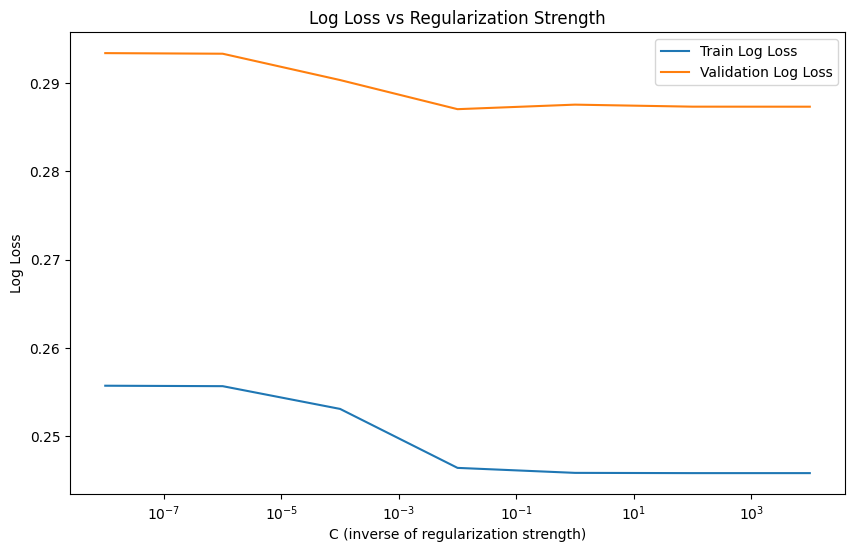

In [77]:
from sklearn.metrics import log_loss

lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []  # Cross-entropy (log loss) para train
lr_push_val_ce = []    # Cross-entropy (log loss) para validation

fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None] #1/alpha
for c in cs:
    lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l2", C=c if c else 1.0),
    )
    lr.fit(X_train[train_cols], y_train)
    
    # Predicciones para train
    train_proba = lr.predict_proba(X_train[train_cols])[:,1]
    train_log_loss = log_loss(y_train, train_proba)
    lr_push_train_ce.append(train_log_loss)
    
    plot_metrics(
        f"LR; C={c}", y_pred=train_proba, y_test=y_train, figure=(fig1, ax1)
    )

    # Predicciones para validation
    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    val_log_loss = log_loss(y_val, val_proba)
    lr_push_val_ce.append(val_log_loss)
    
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=y_val, figure=(fig2, ax2)
    )

# Imprimir los resultados de log loss
print("Train Log Loss values:", lr_push_train_ce)
print("Validation Log Loss values:", lr_push_val_ce)

# También puedes graficar el log loss vs C
plt.figure(figsize=(10, 6))
plt.plot(cs, lr_push_train_ce, label='Train Log Loss')
plt.plot(cs, lr_push_val_ce, label='Validation Log Loss')
plt.xscale('log')
plt.xlabel('C (inverse of regularization strength)')
plt.ylabel('Log Loss')
plt.title('Log Loss vs Regularization Strength')
plt.legend()
plt.show()

* Los dos modelos con mayor regularización (C= 1e-8 y 1e-6) muestran rendimientos similares en train y en validation. 

* No obstante, la regularización no tiene mucho impacto, ya que el modelo lineal no es capaz de capturar patrones posiblemente no lineales

# Lasso Regression

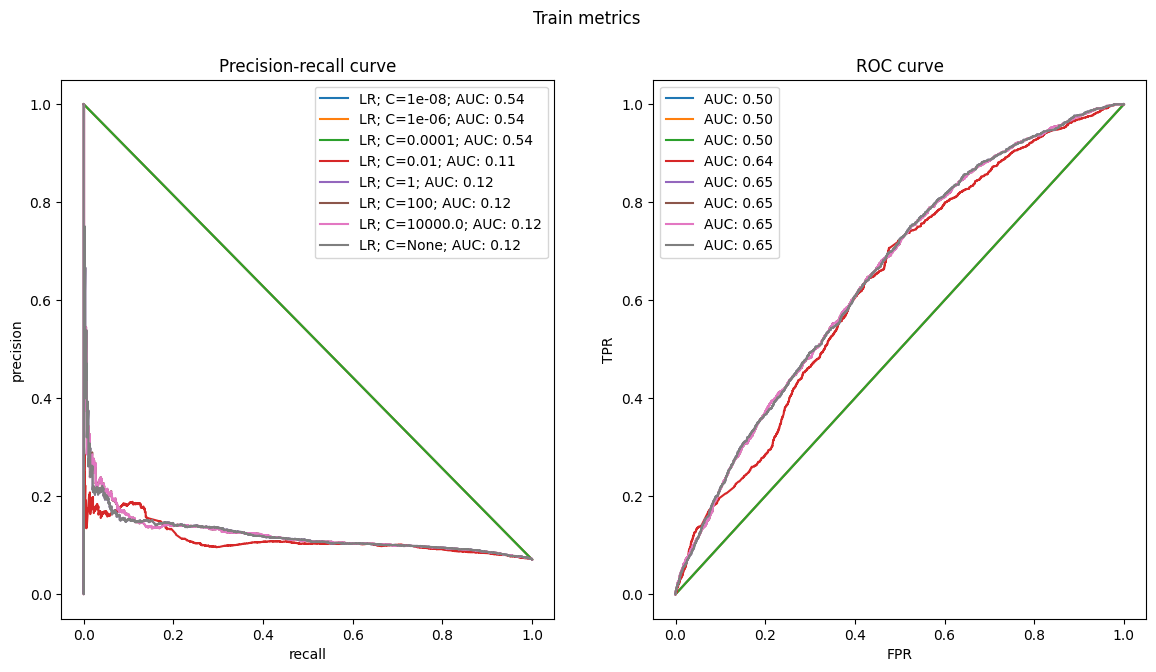

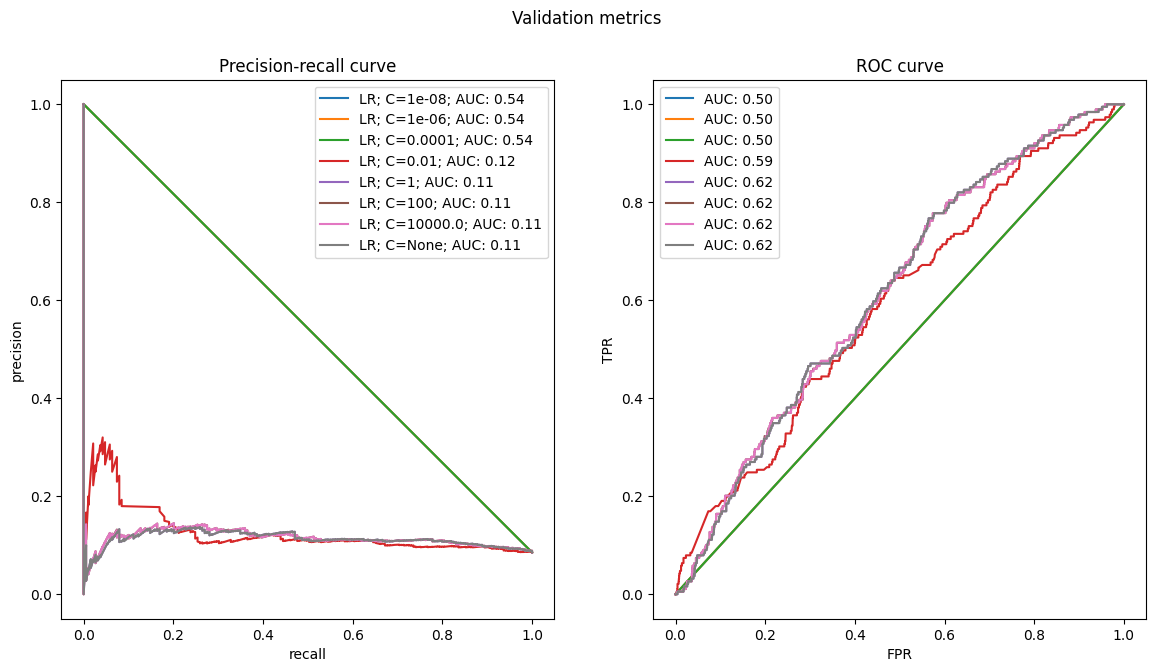

In [78]:
#usar pipelines porque une todos los pasos que forman parte del proceso de entrenamiento

lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []


fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None] #1/alpha
for c in cs:
    lr = make_pipeline(
    StandardScaler(),   #standard escaler necesita .fit para calcular media y desviacion estandar
    LogisticRegression(penalty="l1", C=c if c else 1.0, solver='liblinear'),  # Cambiado a L1 y añadido solver
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:,1]
    plot_metrics(
        f"LR; C={c}", y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
    )

* En este caso el rendimiento en train si que es algo mejor que en validation (en las curvas ROC sobretodo)

Nos podemos quedar con el modelo ridge con C=1e-6 como baseline

# Coefficients weights

In [79]:
lr = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l2", C=1e-6)),  #elijo el que parecia que funcionaba mejor
    ]
)
lr.fit(X_train[train_cols], y_train)
lr_coeff_l2 = pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["lr"].coef_[0]),
        "regularisation": ["l2"] * len(train_cols),
    }
)
lr_coeff_l2 = lr_coeff_l2.sort_values("importance", ascending=True)


lr = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l1", C=1e-2, solver="saga"),)
    ]
)
lr.fit(X_train[train_cols], y_train)
lr_coeff_l1 = pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["lr"].coef_[0]),
        "regularisation": "l1",
    }
)

lr_coeff_l1 = lr_coeff_l1.sort_values("importance", ascending=True)

/Users/alex/Library/Caches/pypoetry/virtualenvs/zrive-ds-BjTOAo2L-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<Axes: xlabel='importance', ylabel='features'>

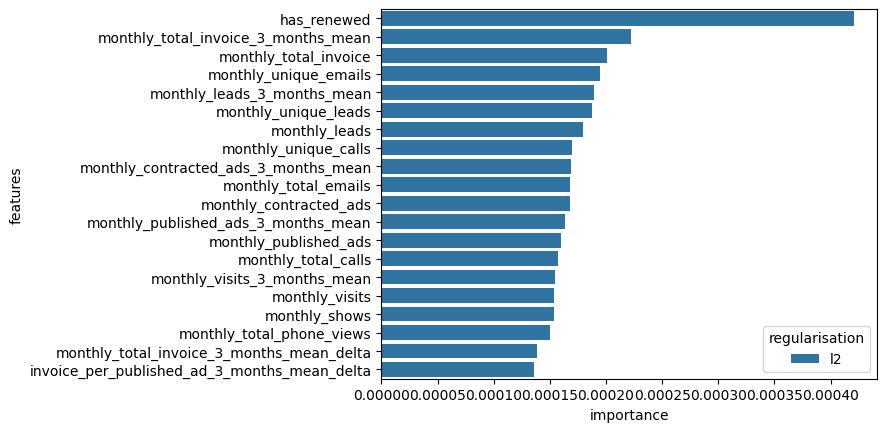

In [80]:
lr_coeff_l2["features"] = pd.Categorical(lr_coeff_l2["features"])
lr_coeff_l2 = lr_coeff_l2.sort_values(by=["importance"])
order_columns = lr_coeff_l2.sort_values(by="importance", ascending = False)["features"]

top_20_features_l2 = lr_coeff_l2.sort_values(by="importance", ascending=False).head(20)

sns.barplot(
    data=top_20_features_l2,
    x="importance",
    y="features",
    hue="regularisation",
    order=top_20_features_l2["features"]
)

<Axes: xlabel='importance', ylabel='features'>

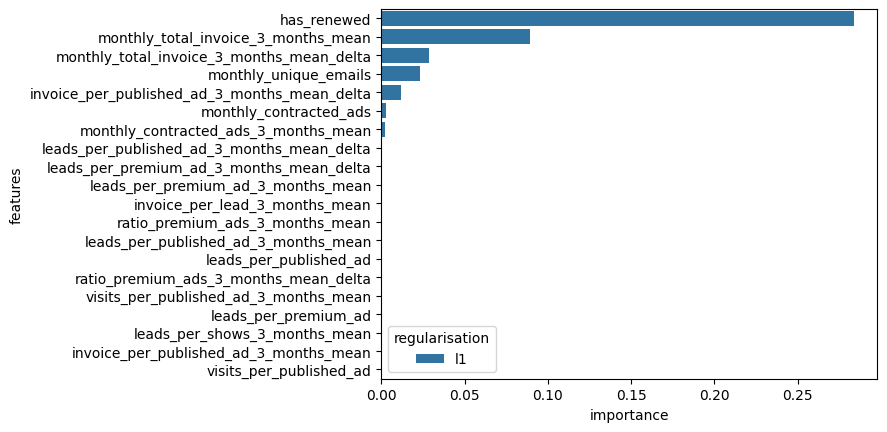

In [81]:
lr_coeff_l1["features"] = pd.Categorical(lr_coeff_l1["features"])
lr_coeff_l1 = lr_coeff_l1.sort_values(by=["importance"])
order_columns = lr_coeff_l1.sort_values(by="importance", ascending = False)["features"]


top_20_features_l1 = lr_coeff_l1.sort_values(by="importance", ascending=False).head(20)


sns.barplot(
    data=top_20_features_l1,
    x="importance",
    y="features",
    hue="regularisation",
    order=top_20_features_l1["features"]
)

Para Lasso, solo importan las variables

* has_renewed

* monthly_total_invoice_3_months_mean

* monthly_total_invoice_3_months_mean_delta

* invoice_per_published_ad_3_months_mean_delta

* monthly_unique_emails

* monthly_oro_ads

* monthly_unique_leads

* monthly_total_invoice

* monthly_leads_3_months_mean

* monthly_visits

* ratio_published_contracted_3_months_mean

Vamos a probar un modelo con L1 y otro con L2 con estas variables unicamente y si el renidmiento es parecido, nos quedamos como baseline este modelo

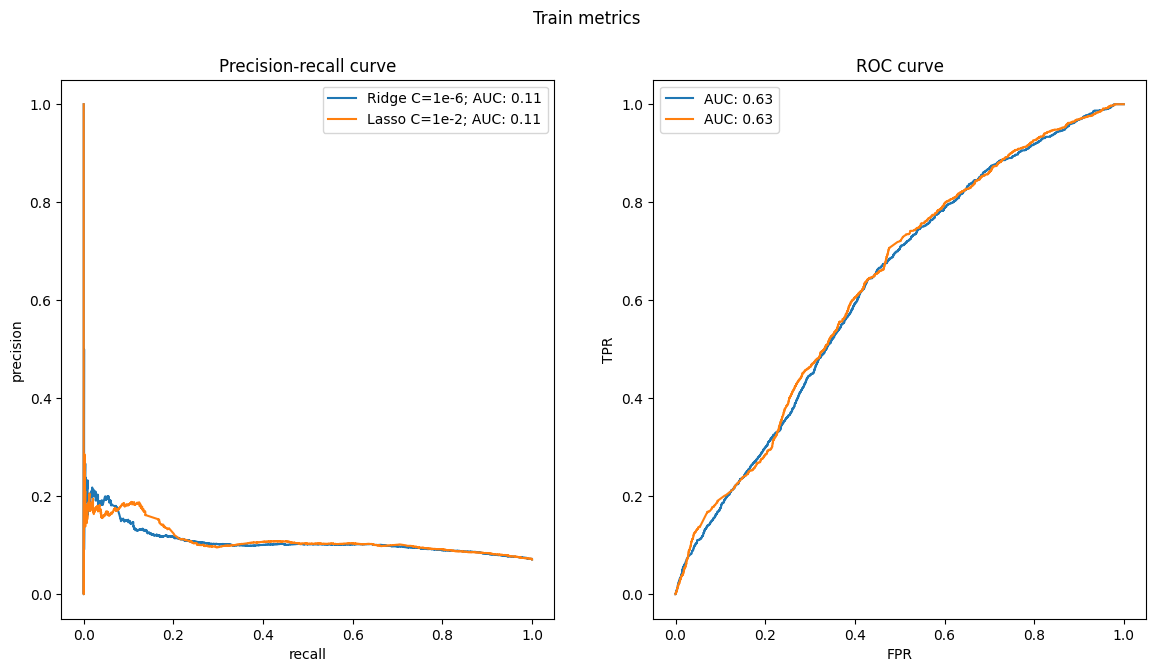

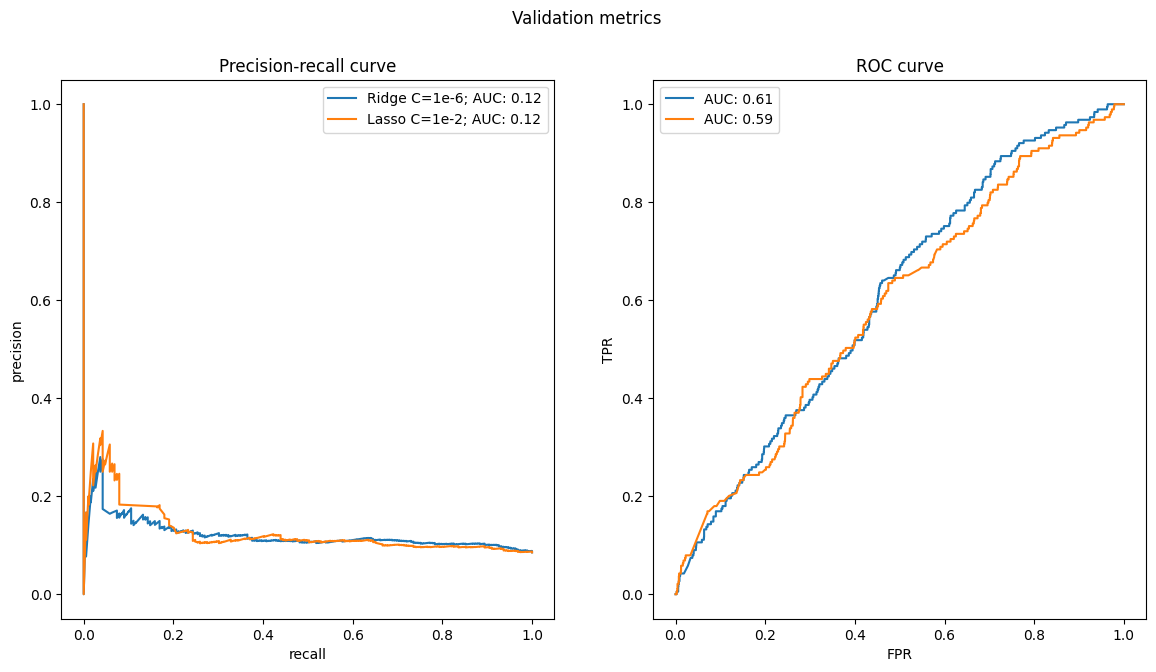

In [82]:
reduced_cols_2 = ["has_renewed", "monthly_total_invoice_3_months_mean", "monthly_total_invoice_3_months_mean_delta", "invoice_per_published_ad_3_months_mean_delta",
 "monthly_unique_emails", "monthly_contracted_ads", "monthly_contracted_ads_3_months_mean"]


reduced_cols = ["has_renewed", "monthly_total_invoice_3_months_mean", "monthly_total_invoice_3_months_mean_delta", "invoice_per_published_ad_3_months_mean_delta",
 "monthly_unique_emails", "monthly_oro_ads", "monthly_unique_leads", "monthly_total_invoice", "monthly_leads_3_months_mean", "monthly_visits",
"ratio_published_contracted_3_months_mean" ]

fig1, ax1 = plt.subplots(1,2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize= (14,7))
fig2.suptitle("Validation metrics")

lrs = [
    make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=1e-6)),
    make_pipeline(
        StandardScaler(), LogisticRegression(penalty="l1", C=1e-2, solver="saga")
    )
]

names = ["Ridge C=1e-6", "Lasso C=1e-2"]
for name, lr in zip(names, lrs):
    lr.fit(X_train[reduced_cols], y_train)
    train_proba = lr.predict_proba(X_train[reduced_cols])[:, 1]
    plot_metrics(
        name, y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

for name, lr in zip(names, lrs):
    lr.fit(X_train[reduced_cols], y_train)
    val_proba = lr.predict_proba(X_val[reduced_cols])[:, 1]
    plot_metrics(
        name, y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
    )



Nos quedamos como baseline con el modelo Ridge

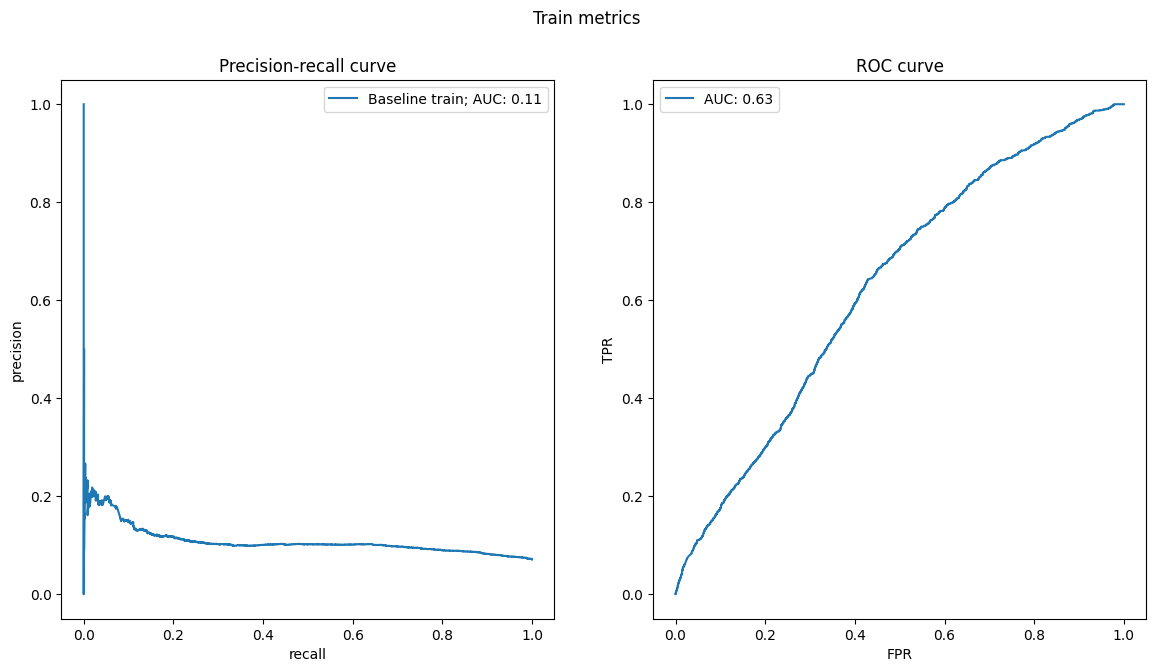

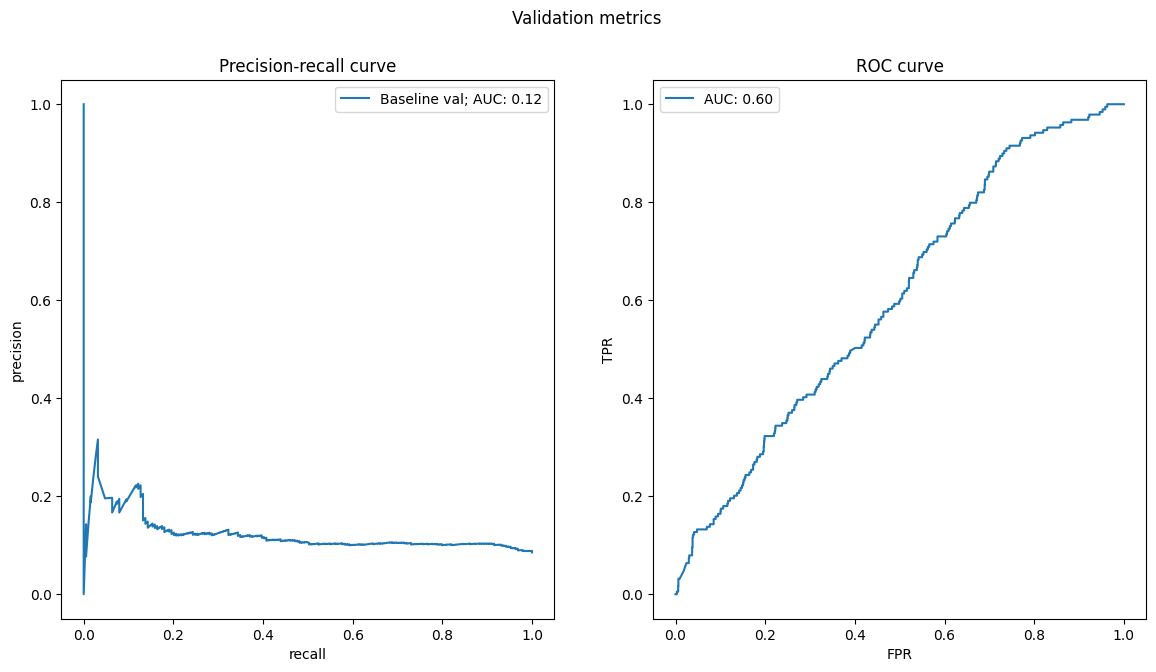

In [83]:
fig1, ax1 = plt.subplots(1,2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

lr =make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=1e-6))

lr.fit(X_train[reduced_cols], y_train)
lr_train_proba = lr.predict_proba(X_train[reduced_cols])[:, 1]

lr.fit(X_val[reduced_cols], y_val)
lr_val_proba = lr.predict_proba(X_val[reduced_cols])[:, 1]

plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)

# Modelos no lineales

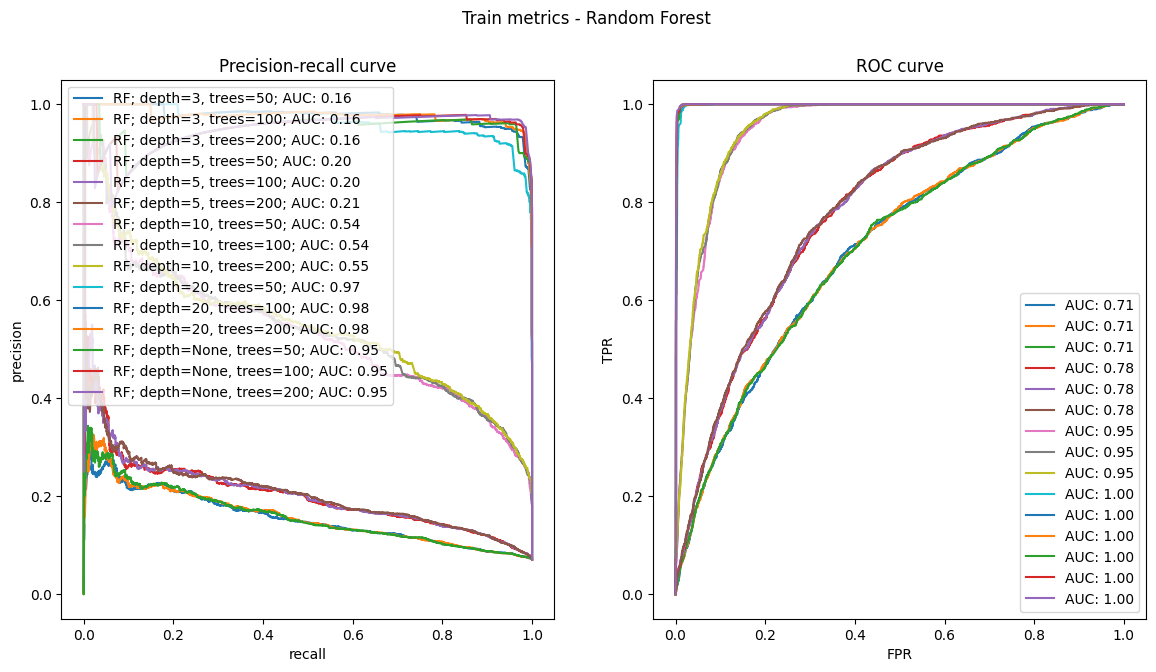

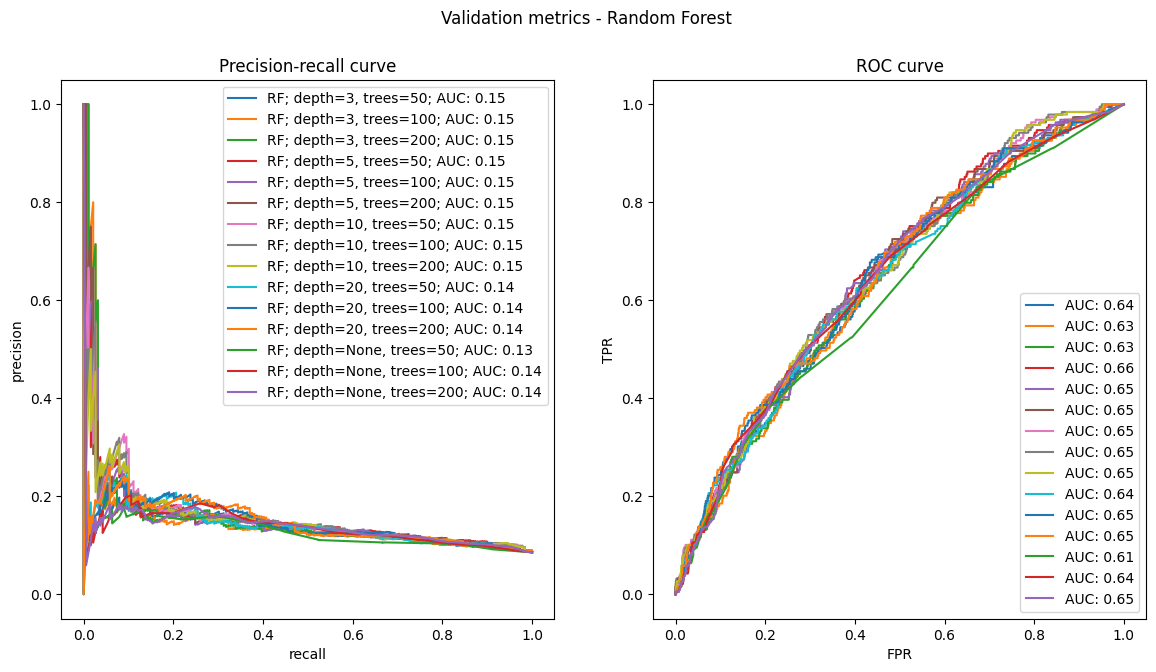

In [84]:
from sklearn.ensemble import RandomForestClassifier

# Configurar parámetros a probar
max_depths = [3, 5, 10, 20, None]
n_estimators_list = [50, 100, 200]

# Configurar plots
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics - Random Forest")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics - Random Forest")

for max_depth in max_depths:
    for n_estimators in n_estimators_list:
        rf = make_pipeline(
            RandomForestClassifier(
                max_depth=max_depth,
                n_estimators=n_estimators,
                random_state=46,
                class_weight='balanced'  # Para manejar desbalance de clases
            )
        )
        
        rf.fit(X_train[train_cols], y_train)

        # Métricas train
        train_proba = rf.predict_proba(X_train[train_cols])[:,1]
        plot_metrics(
            f"RF; depth={max_depth}, trees={n_estimators}", 
            train_proba, 
            y_train,
            figure=(fig1, ax1)
        )

        # Métricas validation
        val_proba = rf.predict_proba(X_val[train_cols])[:,1]
        plot_metrics(
            f"RF; depth={max_depth}, trees={n_estimators}", 
            val_proba,
            y_val,
            figure=(fig2, ax2)
        )



en random forest, aunque el rendimiento sea mucho mejor que en train que en validation, no es overfitting 

random forest con columnas de lasso, ya que si tenemos muchas features que no aportan, muchos arboles van a ser malos y no aportar

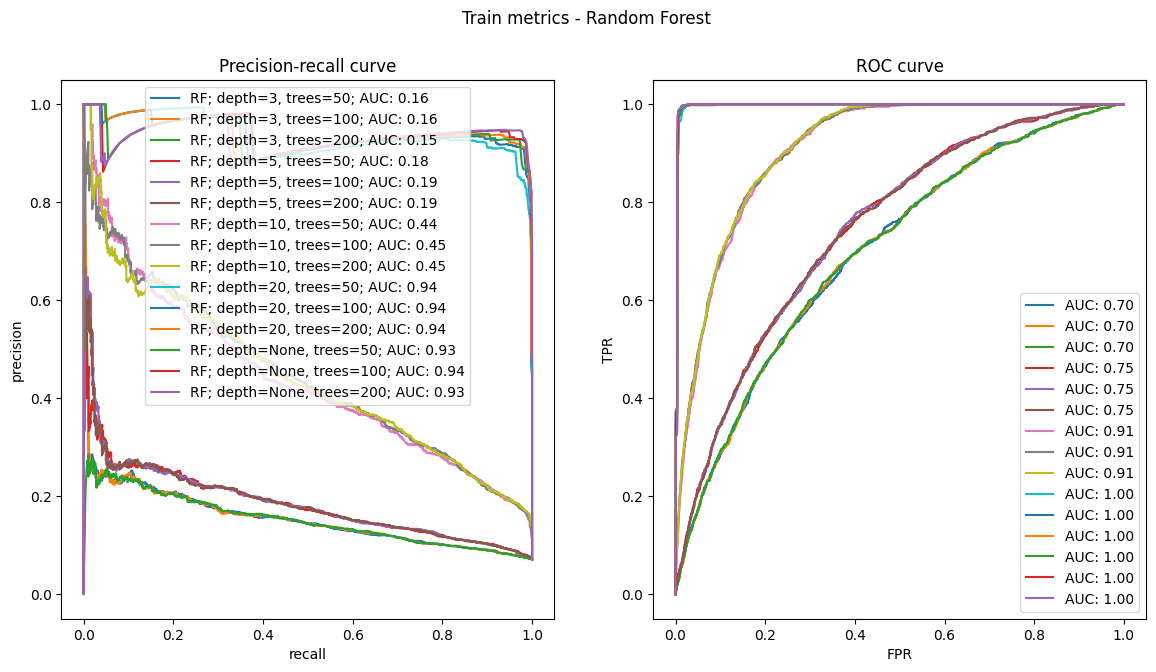

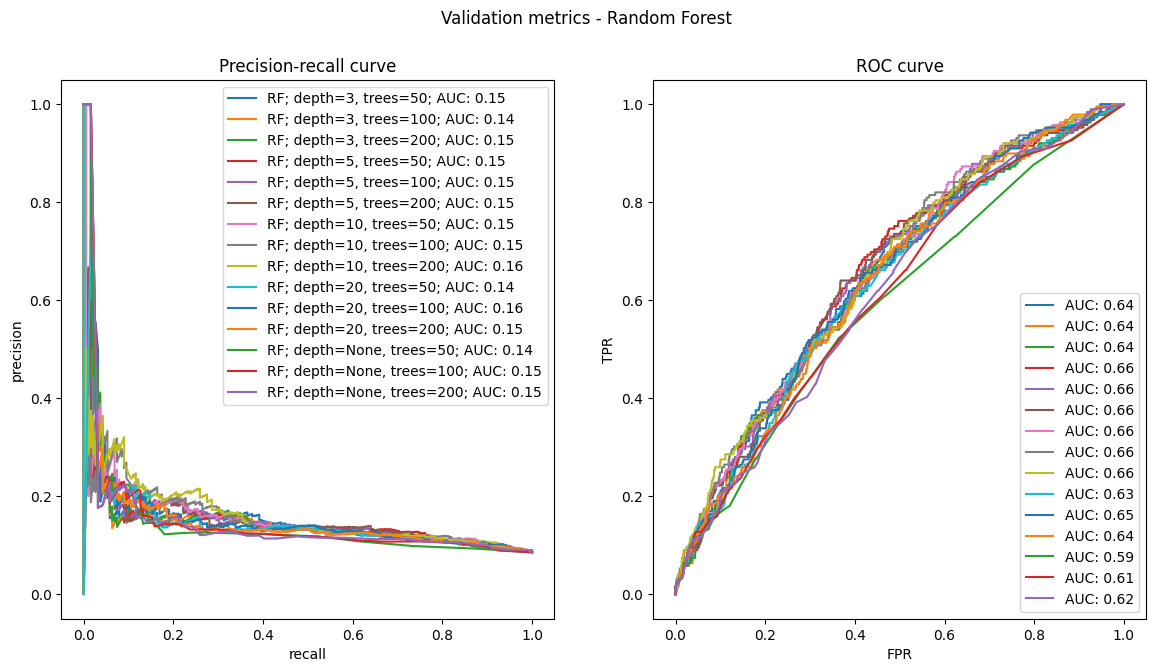

In [85]:
from sklearn.ensemble import RandomForestClassifier

# Configurar parámetros a probar
max_depths = [3, 5, 10, 20, None]
n_estimators_list = [50, 100, 200]

# Configurar plots
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics - Random Forest")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics - Random Forest")

for max_depth in max_depths:
    for n_estimators in n_estimators_list:
        rf = make_pipeline(
            RandomForestClassifier(
                max_depth=max_depth,
                n_estimators=n_estimators,
                random_state=46,
                class_weight='balanced'  # Para manejar desbalance de clases
            )
        )
        
        rf.fit(X_train[reduced_cols], y_train)

        # Métricas train
        train_proba = rf.predict_proba(X_train[reduced_cols])[:,1]
        plot_metrics(
            f"RF; depth={max_depth}, trees={n_estimators}", 
            train_proba, 
            y_train,
            figure=(fig1, ax1)
        )

        # Métricas validation
        val_proba = rf.predict_proba(X_val[reduced_cols])[:,1]
        plot_metrics(
            f"RF; depth={max_depth}, trees={n_estimators}", 
            val_proba,
            y_val,
            figure=(fig2, ax2)
        )

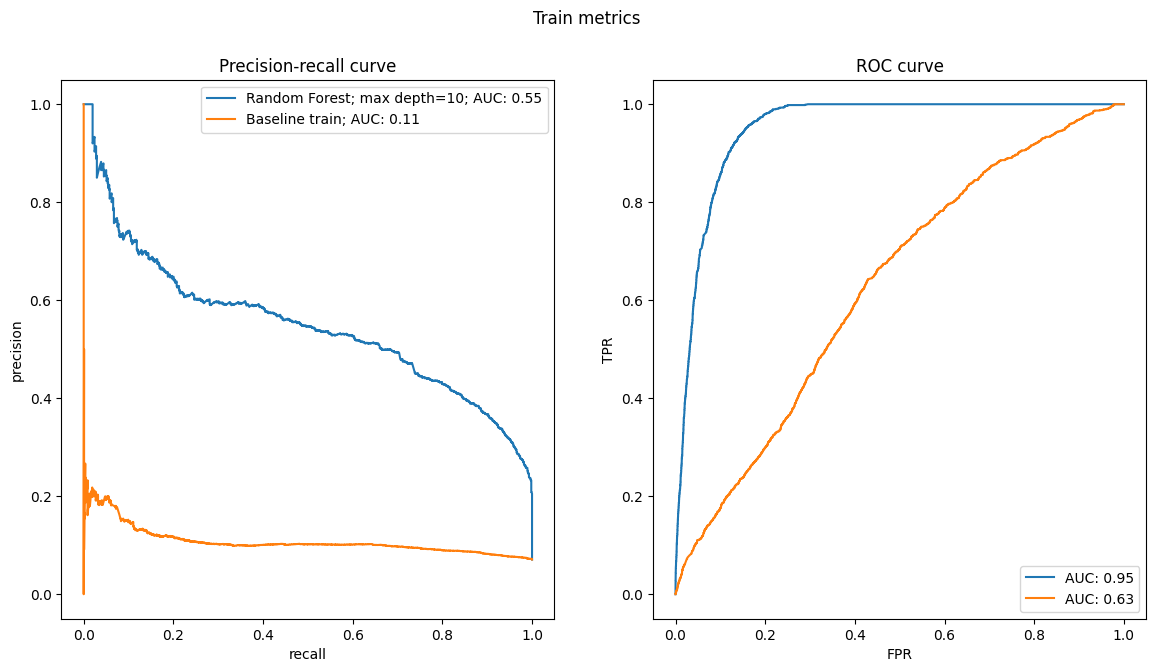

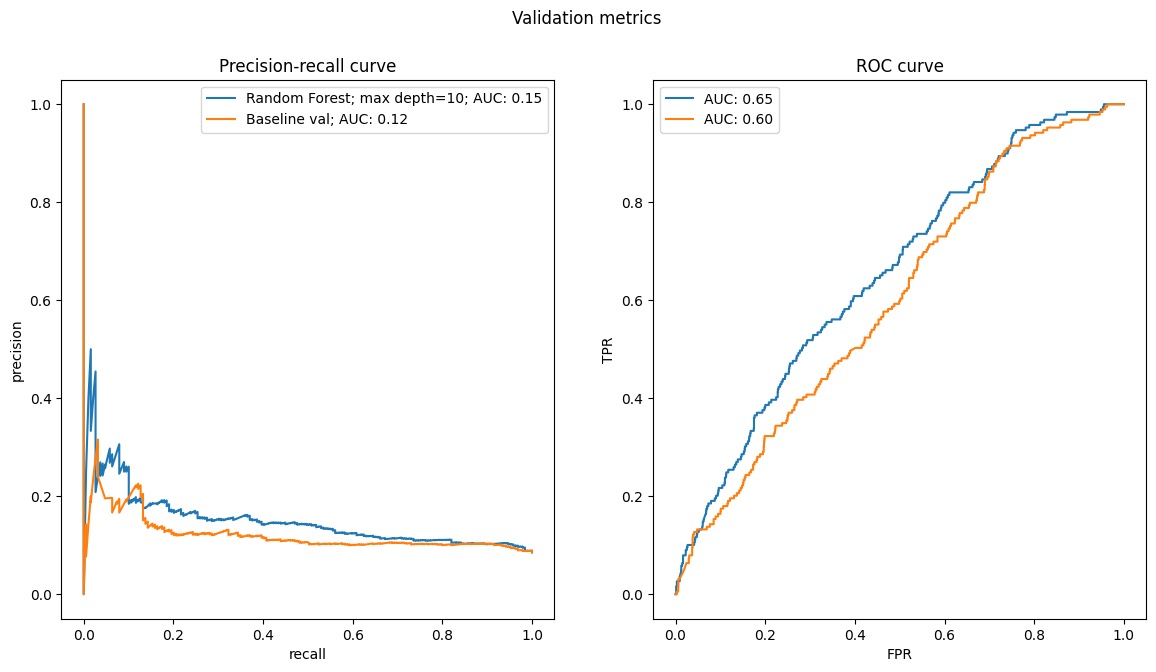

In [86]:
fig1, ax1 = plt.subplots(1,2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")



selected_max_depth = 10
selected_n_estimators=100

selected_rf = make_pipeline(
    RandomForestClassifier(
    max_depth=selected_max_depth,
    n_estimators=n_estimators,
    random_state=46,
    class_weight='balanced'  # Para manejar desbalance de clases
    )
)

selected_rf.fit(X_train[train_cols], y_train)
rf_train_proba = selected_rf.predict_proba(X_train[train_cols])[:, 1]
plot_metrics(
    f"Random Forest; max depth={selected_max_depth}", y_pred=rf_train_proba, y_test=train_df[label_col], figure=(fig1,ax1)
)

rf_val_proba = selected_rf.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(
    f"Random Forest; max depth={selected_max_depth}", y_pred=rf_val_proba, y_test=val_df[label_col], figure=(fig2,ax2)
)



plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)

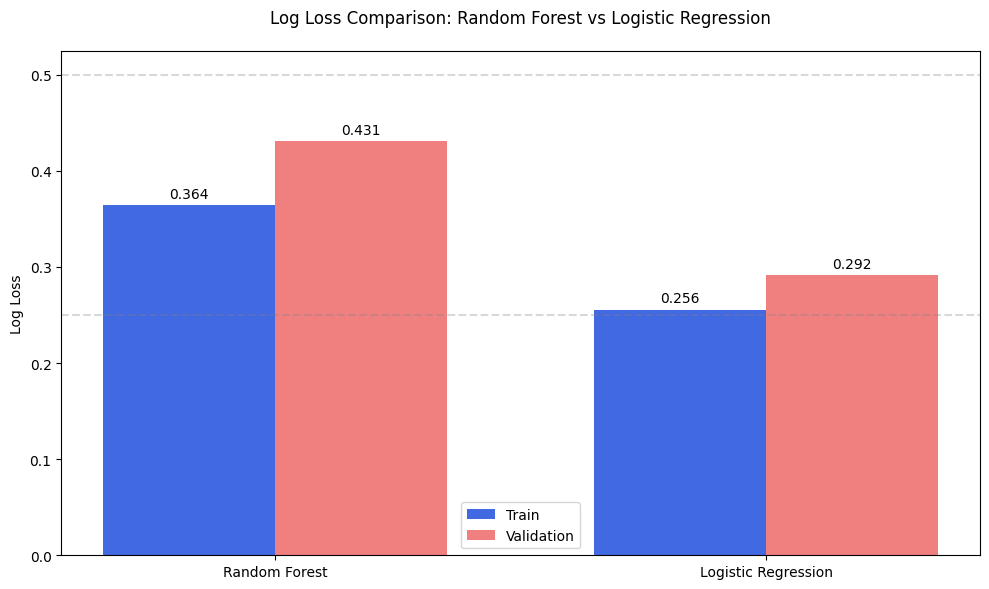

In [89]:
from sklearn.metrics import log_loss

# Calcular Log Loss para ambos modelos
# Random Forest
rf_train_logloss = log_loss(y_train, rf_train_proba)
rf_val_logloss = log_loss(y_val, rf_val_proba)

# Baseline (Regresión Logística)
lr_train_logloss = log_loss(y_train, lr_train_proba)
lr_val_logloss = log_loss(y_val, lr_val_proba)

# Crear visualización comparativa
fig, ax = plt.subplots(figsize=(10, 6))

# Posiciones de las barras
bar_width = 0.35
index = np.arange(2)

# Datos para graficar
train_losses = [rf_train_logloss, lr_train_logloss]
val_losses = [rf_val_logloss, lr_val_logloss]

# Crear barras
bars1 = ax.bar(index, train_losses, bar_width, label='Train', color='royalblue')
bars2 = ax.bar(index + bar_width, val_losses, bar_width, label='Validation', color='lightcoral')

# Añadir valores encima de las barras
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

# Personalizar gráfico
ax.set_title('Log Loss Comparison: Random Forest vs Logistic Regression', pad=20)
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(['Random Forest', 'Logistic Regression'])
ax.set_ylabel('Log Loss')
ax.legend()

# Añadir línea horizontal de referencia
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
ax.axhline(y=0.25, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [88]:
aquiii

NameError: name 'aquiii' is not defined

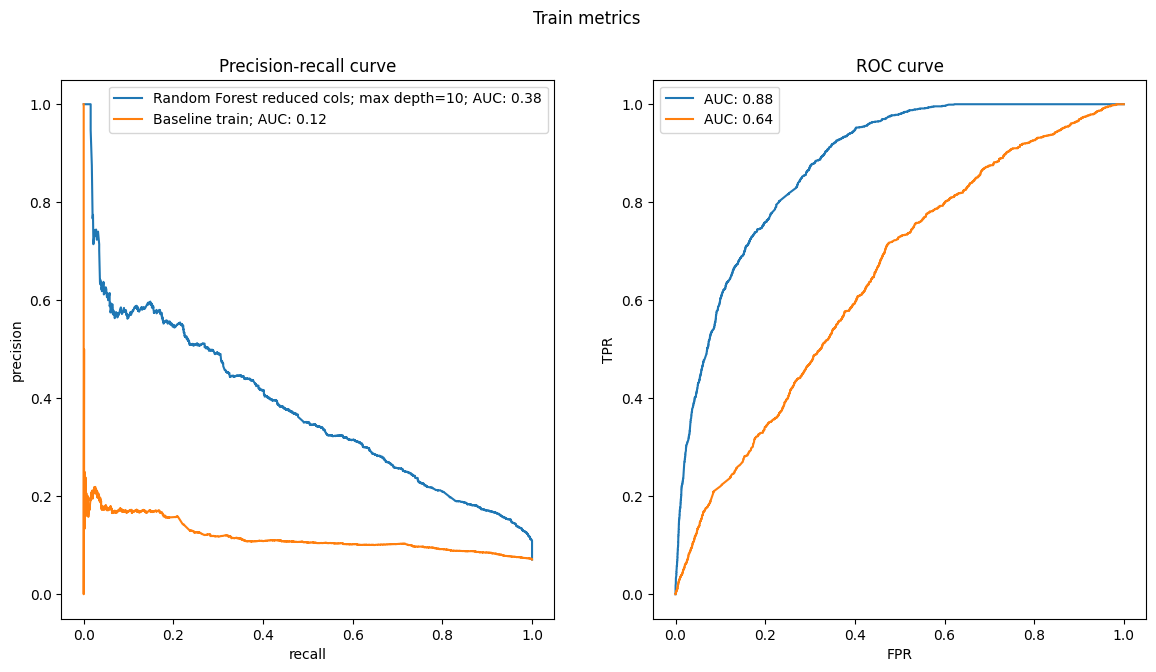

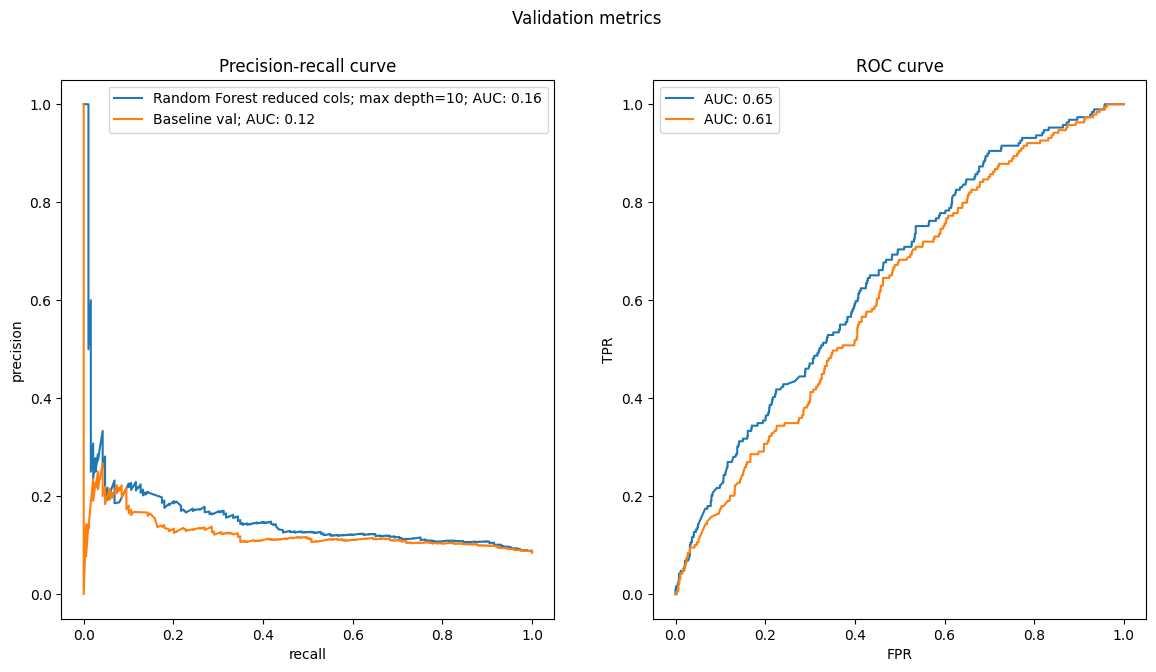

In [ ]:
fig1, ax1 = plt.subplots(1,2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")



selected_max_depth = 10
selected_n_estimators=100

selected_rf = make_pipeline(
    RandomForestClassifier(
    max_depth=selected_max_depth,
    n_estimators=n_estimators,
    random_state=46,
    class_weight='balanced'  # Para manejar desbalance de clases
    )
)

selected_rf.fit(X_train[reduced_cols], y_train)
rf_train_proba = selected_rf.predict_proba(X_train[reduced_cols])[:, 1]
plot_metrics(
    f"Random Forest reduced cols; max depth={selected_max_depth}", y_pred=rf_train_proba, y_test=train_df[label_col], figure=(fig1,ax1)
)

rf_val_proba = selected_rf.predict_proba(X_val[reduced_cols])[:, 1]
plot_metrics(
    f"Random Forest reduced cols; max depth={selected_max_depth}", y_pred=rf_val_proba, y_test=val_df[label_col], figure=(fig2,ax2)
)



plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)

0.15 > 0.12

In [ ]:
#gradient boosting, pruebas

In [ ]:
param_dist = {
    'n_estimators': [5, 10, 15, 20],  
    'max_depth': [3, 5, 7, 9],            
    'learning_rate': [0.01, 0.1, 0.2],   
    'subsample': [0.6, 0.8, 1.0],        
    'colsample_bytree': [0.6, 0.8, 1.0],  
    'reg_alpha': [0, 0.1, 1],             # Regularización L1 (alpha)
    'reg_lambda': [0, 0.1, 1],            # Regularización L2 (lambda)
    'gamma': [0, 0.1, 0.2],               # Reducción mínima de pérdida para dividir un nodo
}

In [ ]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='roc_auc',  
    cv=3,               
    n_jobs=-1,       
    verbose=2,        
    random_state=42      
)

In [ ]:
random_search.fit(X_train[train_cols], y_train)


print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor puntuación (AUC-ROC):", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=20, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=20, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=9, n_estimators=10, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=9, n_estimators=10, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=9, n_estimators=10, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=5, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_b

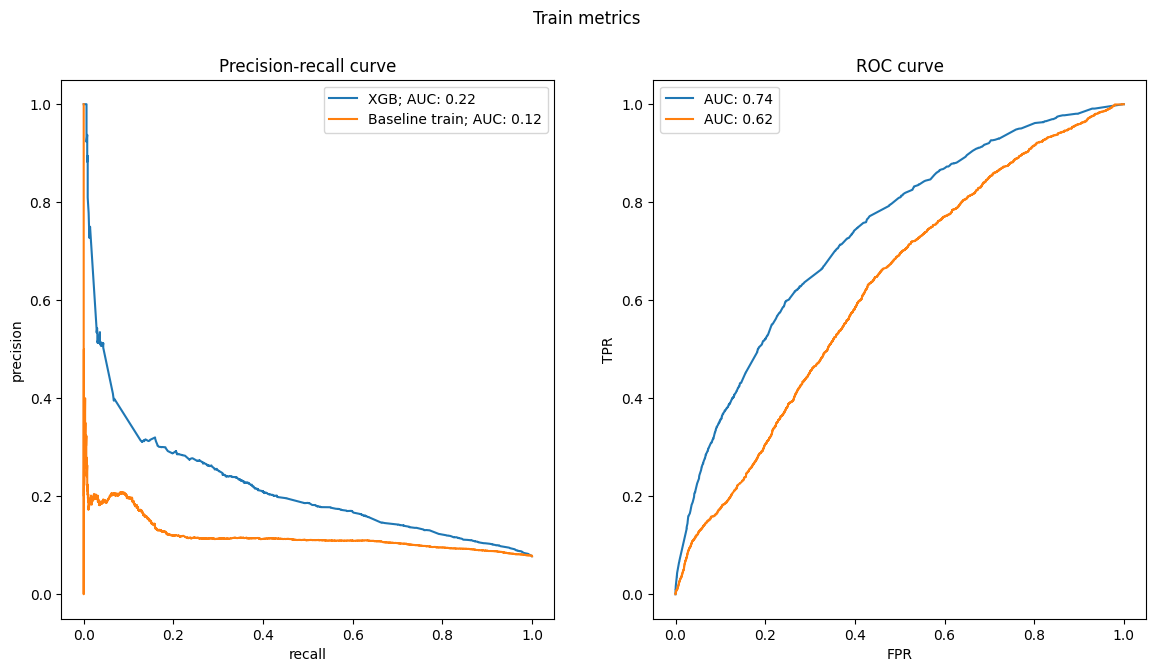

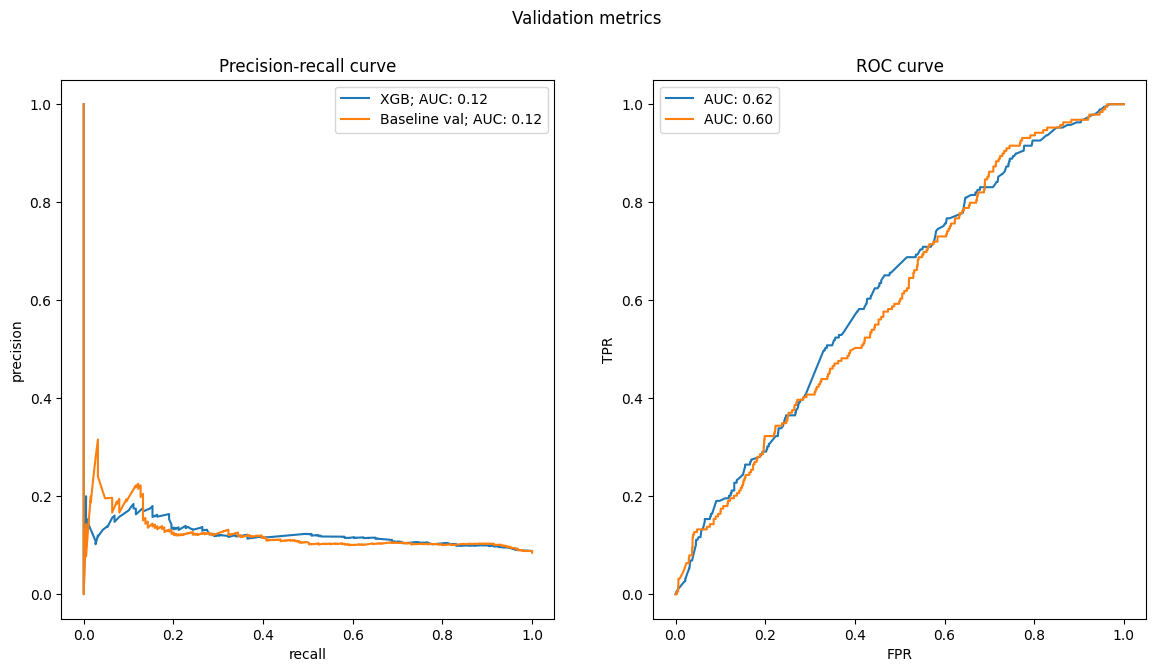

In [ ]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")


xg = make_pipeline(
    xgb.XGBClassifier(
    objective='binary:logistic',  
    n_estimators=3,            
    max_depth=5,                 
    learning_rate=0.01,         
    subsample=0.8,            
    colsample_bytree=0.6,
    reg_lambda=0.1,
    reg_alpha=0.1,
    gamma=0       
)
)

xg.fit(X_train[train_cols], y_train)
xg_train_proba = xg.predict_proba(X_train[train_cols])[:, 1]
plot_metrics(
    f"XGB", y_pred=xg_train_proba, y_test=train_df[label_col], figure=(fig1,ax1)
)

xg_val_proba = xg.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(
    f"XGB", y_pred=xg_val_proba, y_test=val_df[label_col], figure=(fig2,ax2)
)


plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.6 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.6 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Info] Number of positive: 1903, number of nega

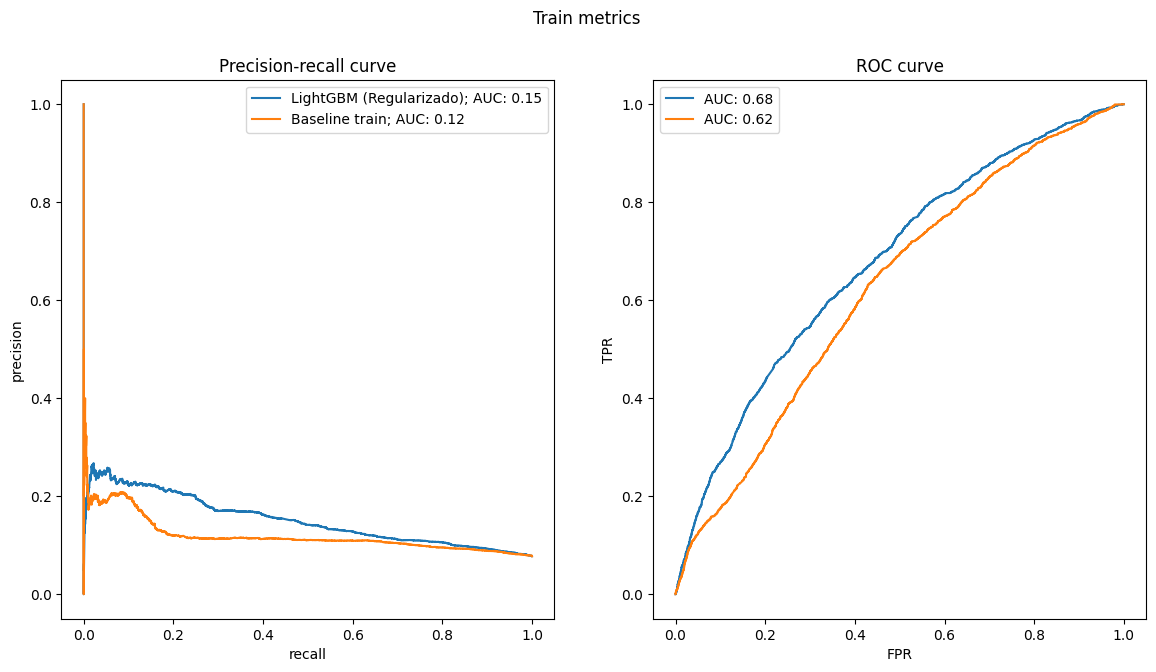

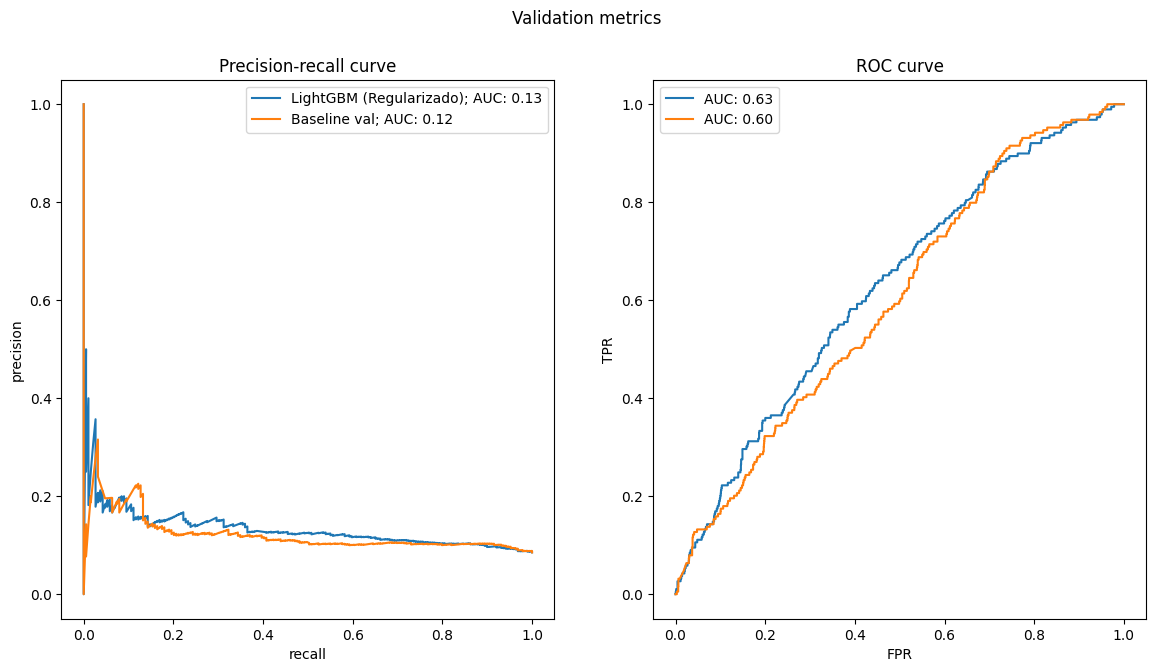

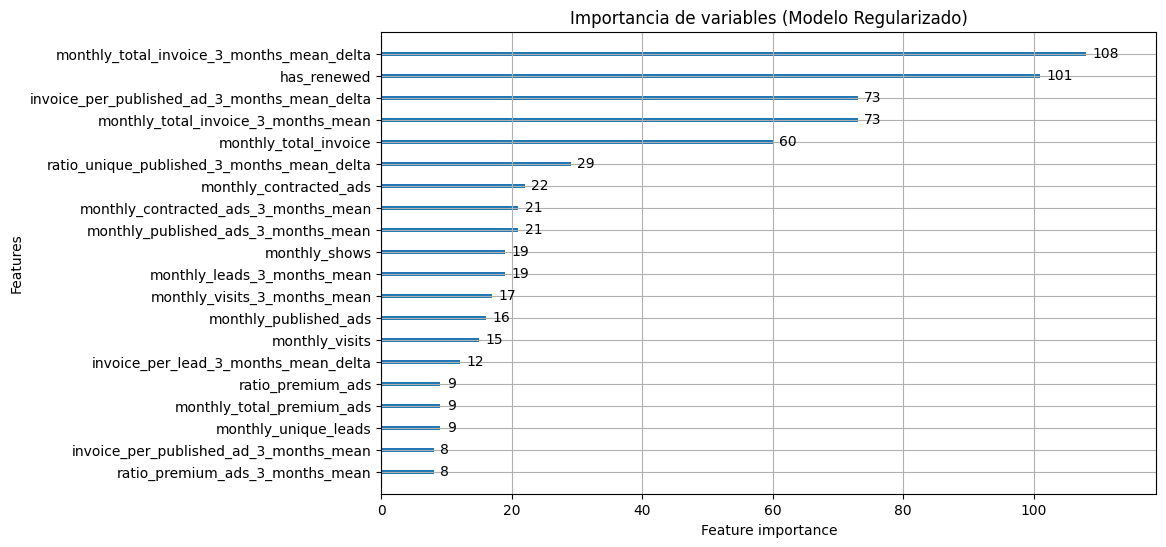

In [ ]:
import lightgbm as lgb
from sklearn.pipeline import make_pipeline

# Configuración de las figuras
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

# Modelo LightGBM con MÁXIMA regularización
lgbm = make_pipeline(
    lgb.LGBMClassifier(
        objective='binary',
        n_estimators=200,               # Más árboles pero con early stopping
        max_depth=3,                    # Reducción drástica de profundidad
        learning_rate=0.01,             # Learning rate más bajo
        subsample=0.6,                  # Menos muestras por árbol
        colsample_bytree=0.5,           # Menos features por árbol
        reg_lambda=3.0,                 # Regularización L2 muy alta
        reg_alpha=2.0,                  # Regularización L1 muy alta
        min_child_weight=5,             # Peso mínimo más alto
        min_split_gain=0.3,             # Ganancia mínima más exigente
        num_leaves=15,                  # Reducción drástica de hojas
        boosting_type='dart',           # Boosting con dropout
        drop_rate=0.1,                  # 10% de dropout
        max_bin=150,                    # Reducir granularidad de splits
        min_data_in_leaf=20,            # Mínimo de datos por hoja
        feature_fraction=0.5,           # Solo 50% de features por iteración
        bagging_freq=1,                 # Frecuencia de bagging
        bagging_fraction=0.7,           #% 70% de datos por iteración
        extra_trees=True,               # Modo más conservador
        importance_type='split',
        n_jobs=-1
    )
)

# Entrenamiento CON EARLY STOPPING
lgbm.fit(
    X_train[train_cols], y_train,
    lgbmclassifier__eval_set=[(X_val[train_cols], y_val)],
    lgbmclassifier__eval_metric='auc'
)

# Predicciones y métricas
lgbm_train_proba = lgbm.predict_proba(X_train[train_cols])[:, 1]
plot_metrics(
    "LightGBM (Regularizado)", y_pred=lgbm_train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
)

lgbm_val_proba = lgbm.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(
    "LightGBM (Regularizado)", y_pred=lgbm_val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
)

# Baseline
plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
)

# Importancia de variables (para diagnóstico)
lgbm_model = lgbm.named_steps['lgbmclassifier']
lgb.plot_importance(lgbm_model, max_num_features=20, figsize=(10, 6))
plt.title('Importancia de variables (Modelo Regularizado)')
plt.show()

Top 20 features seleccionadas:
['monthly_total_invoice_3_months_mean_delta', 'has_renewed', 'monthly_total_invoice_3_months_mean', 'invoice_per_published_ad_3_months_mean_delta', 'monthly_total_invoice', 'ratio_unique_published_3_months_mean_delta', 'monthly_contracted_ads', 'monthly_published_ads_3_months_mean', 'monthly_contracted_ads_3_months_mean', 'monthly_leads_3_months_mean', 'monthly_shows', 'monthly_visits_3_months_mean', 'monthly_published_ads', 'monthly_visits', 'invoice_per_lead_3_months_mean_delta', 'monthly_unique_leads', 'monthly_total_premium_ads', 'ratio_premium_ads', 'monthly_published_ads_3_months_mean_delta', 'monthly_leads']
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.7 will be ignored. Current valu

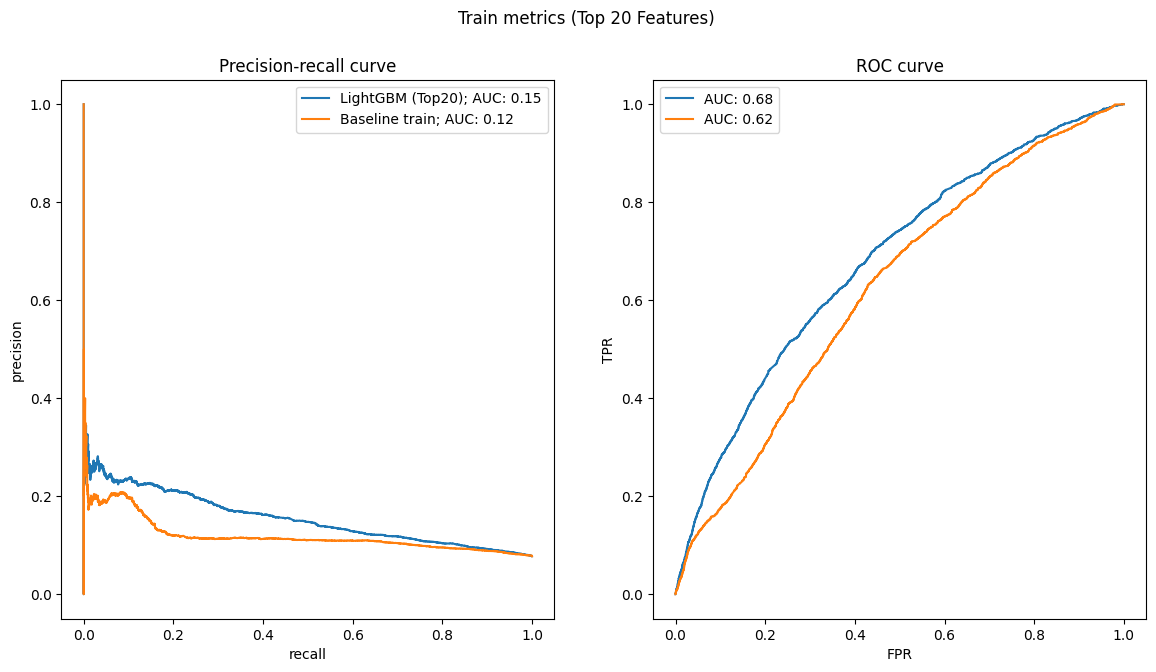

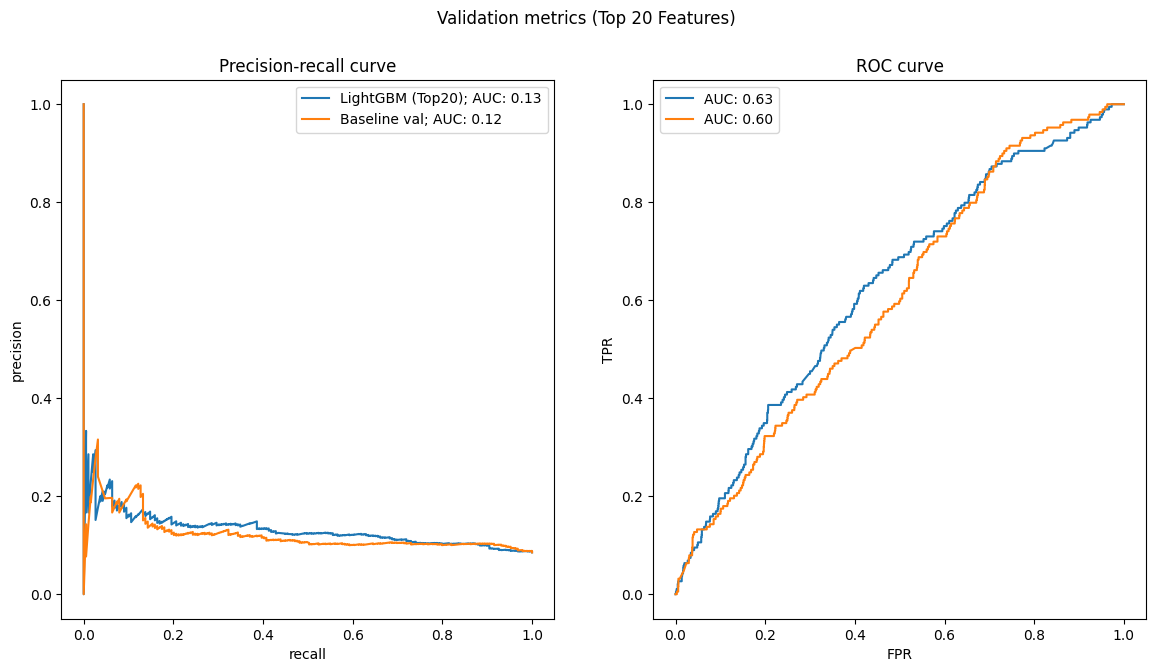

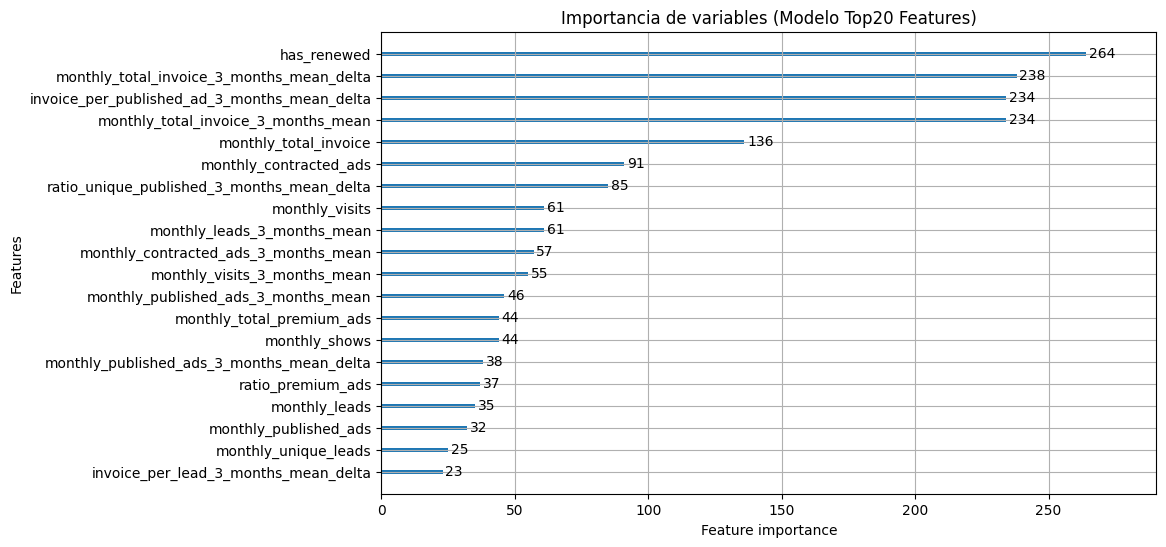


Comparación AUC:
- Train (Full Features): 0.676
- Val (Full Features): 0.627
- Train (Top20): 0.680
- Val (Top20): 0.626


In [ ]:
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# 1. Obtener las 20 features más importantes del modelo anterior
lgbm_model = lgbm.named_steps['lgbmclassifier']
importance = lgbm_model.feature_importances_
feature_names = X_train[train_cols].columns
top_20_features = feature_names[sorted(range(len(importance)), key=lambda i: importance[i], reverse=True)[:20]]

print("Top 20 features seleccionadas:")
print(top_20_features.tolist())

# 2. Configuración de las figuras
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics (Top 20 Features)")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics (Top 20 Features)")

# 3. Modelo LightGBM con LAS 20 FEATURES + regularización extrema
lgbm_top20 = make_pipeline(
    lgb.LGBMClassifier(
        objective='binary',
        n_estimators=300,               # Más árboles por el early stopping
        max_depth=3,                    # Profundidad reducida
        learning_rate=0.01,             # Learning rate bajo
        subsample=0.6,                  # Menos muestras por árbol
        colsample_bytree=0.7,           # Features por árbol
        reg_lambda=3.0,                 # Regularización L2 alta
        reg_alpha=1.5,                  # Regularización L1 alta
        min_child_weight=5,             # Peso mínimo en hojas
        min_split_gain=0.2,             # Ganancia mínima para splits
        num_leaves=15,                  # Pocas hojas
        boosting_type='dart',           # Boosting con dropout
        drop_rate=0.1,                  # Tasa de dropout
        max_bin=150,                    # Bins reducidos
        min_data_in_leaf=20,            # Mínimo datos por hoja
        feature_fraction=0.7,           #% Fracción de features
        extra_trees=True,               # Splits más aleatorios
        importance_type='split',
        n_jobs=-1
    )
)

# 4. Entrenamiento CON EARLY STOPPING
lgbm_top20.fit(
    X_train[top_20_features], y_train,
    lgbmclassifier__eval_set=[(X_val[top_20_features], y_val)],
    lgbmclassifier__eval_metric='auc',
)

# 5. Predicciones y métricas (train)
lgbm_top20_train_proba = lgbm_top20.predict_proba(X_train[top_20_features])[:, 1]
plot_metrics(
    "LightGBM (Top20)", y_pred=lgbm_top20_train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
)

# 6. Predicciones y métricas (validation)
lgbm_top20_val_proba = lgbm_top20.predict_proba(X_val[top_20_features])[:, 1]
plot_metrics(
    "LightGBM (Top20)", y_pred=lgbm_top20_val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
)

# 7. Baseline (usando solo top 20 features)
# (Asumiendo que lr_train_proba y lr_val_proba existen)
plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
)
plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
)

# 8. Nueva importancia de variables (para verificar)
final_model = lgbm_top20.named_steps['lgbmclassifier']
lgb.plot_importance(final_model, max_num_features=20, figsize=(10, 6))
plt.title('Importancia de variables (Modelo Top20 Features)')
plt.show()

# 9. Comparación de métricas clave
print("\nComparación AUC:")
print(f"- Train (Full Features): {roc_auc_score(y_train, lgbm_train_proba):.3f}")
print(f"- Val (Full Features): {roc_auc_score(y_val, lgbm_val_proba):.3f}")
print(f"- Train (Top20): {roc_auc_score(y_train, lgbm_top20_train_proba):.3f}")
print(f"- Val (Top20): {roc_auc_score(y_val, lgbm_top20_val_proba):.3f}")

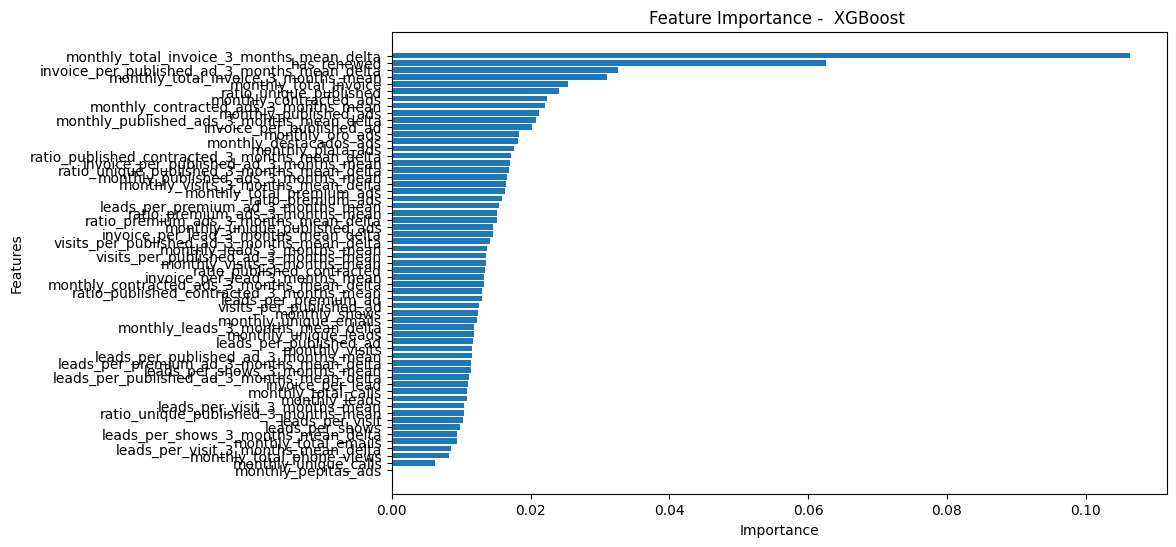

In [ ]:
importances_xg = xg.named_steps['xgbclassifier'].feature_importances_
feature_names_xg = X_train[train_cols].columns
indices_xg = np.argsort(importances_xg)


plt.figure(figsize=(10, 6))
plt.title("Feature Importance -  XGBoost ")
plt.barh(range(len(importances_xg)), importances_xg[indices_xg], align="center")
plt.yticks(range(len(importances_xg)), feature_names_xg[indices_xg])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [ ]:
#reduced cols

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.6 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.6 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Info] Number of positive: 1089, number of nega

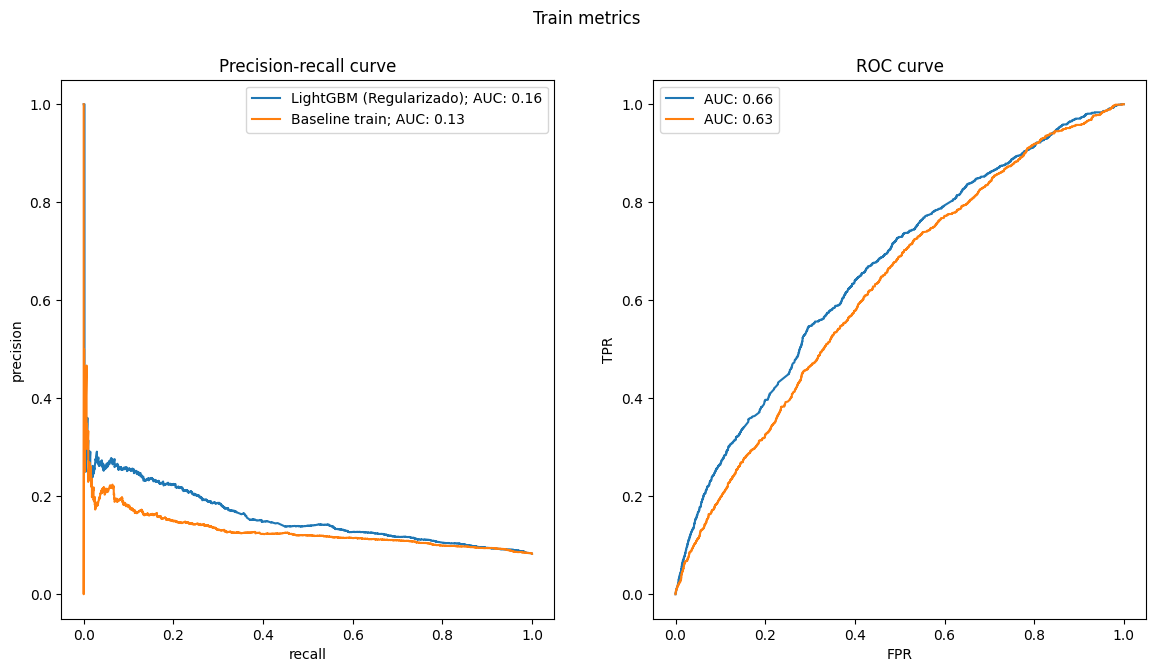

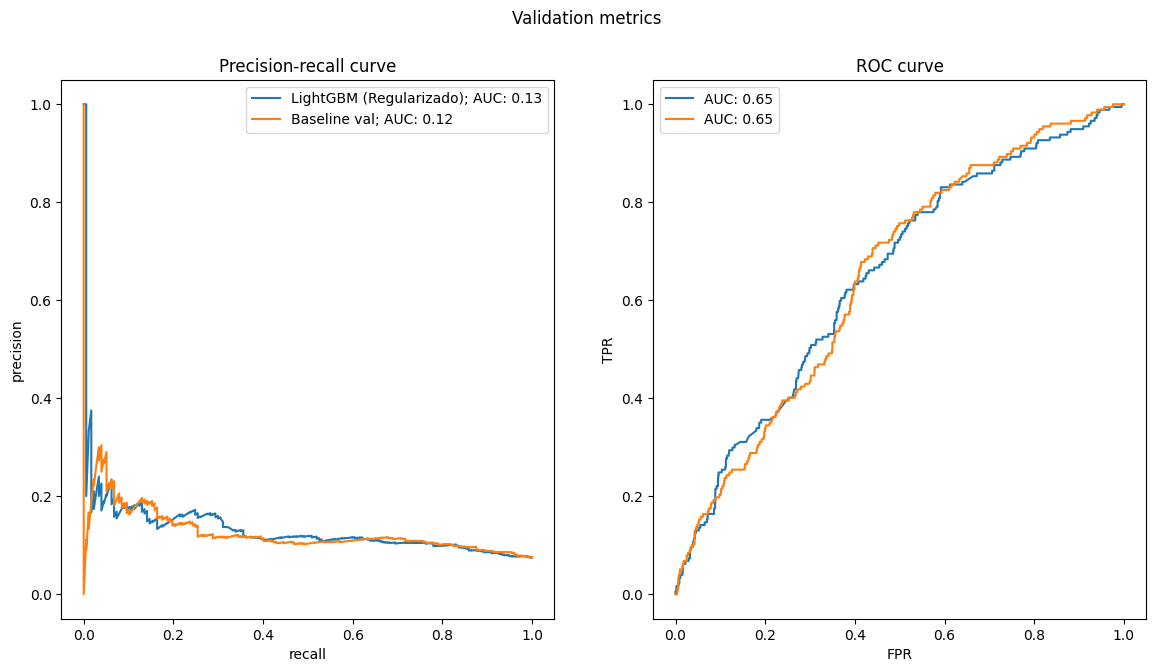

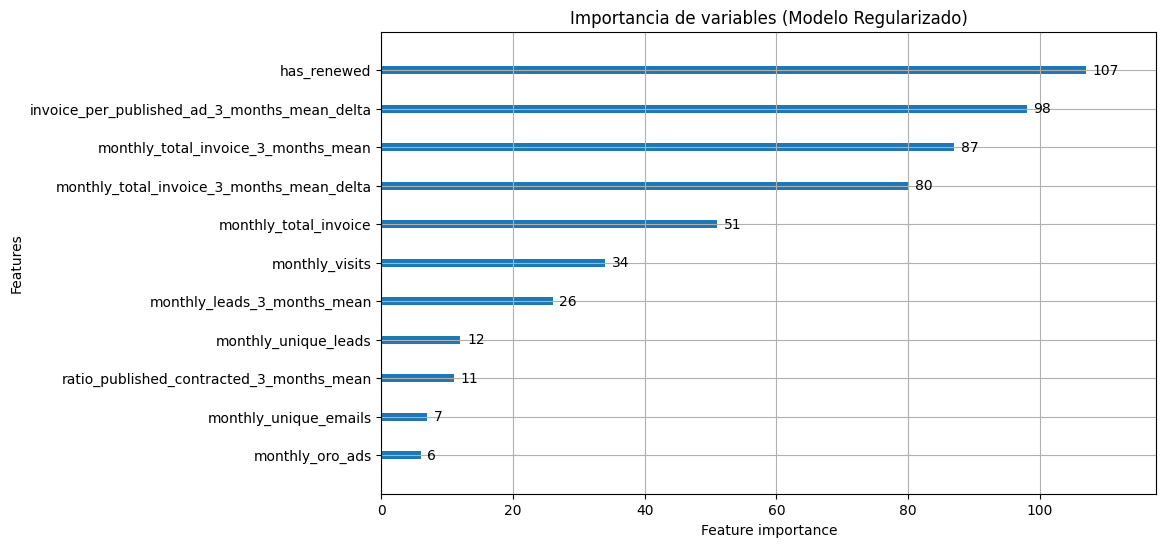

In [ ]:
import lightgbm as lgb
from sklearn.pipeline import make_pipeline

# Configuración de las figuras
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

# Modelo LightGBM con MÁXIMA regularización
lgbm = make_pipeline(
    lgb.LGBMClassifier(
        objective='binary',
        n_estimators=200,               # Más árboles pero con early stopping
        max_depth=3,                    # Reducción drástica de profundidad
        learning_rate=0.01,             # Learning rate más bajo
        subsample=0.6,                  # Menos muestras por árbol
        colsample_bytree=0.5,           # Menos features por árbol
        reg_lambda=3.0,                 # Regularización L2 muy alta
        reg_alpha=2.0,                  # Regularización L1 muy alta
        min_child_weight=5,             # Peso mínimo más alto
        min_split_gain=0.3,             # Ganancia mínima más exigente
        num_leaves=15,                  # Reducción drástica de hojas
        boosting_type='dart',           # Boosting con dropout
        drop_rate=0.1,                  # 10% de dropout
        max_bin=150,                    # Reducir granularidad de splits
        min_data_in_leaf=20,            # Mínimo de datos por hoja
        feature_fraction=0.5,           # Solo 50% de features por iteración
        bagging_freq=1,                 # Frecuencia de bagging
        bagging_fraction=0.7,           #% 70% de datos por iteración
        extra_trees=True,               # Modo más conservador
        importance_type='split',
        n_jobs=-1
    )
)

# Entrenamiento CON EARLY STOPPING
lgbm.fit(
    X_train[reduced_cols], y_train,
    lgbmclassifier__eval_set=[(X_val[reduced_cols], y_val)],
    lgbmclassifier__eval_metric='auc'
)

# Predicciones y métricas
lgbm_train_proba = lgbm.predict_proba(X_train[reduced_cols])[:, 1]
plot_metrics(
    "LightGBM (Regularizado)", y_pred=lgbm_train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
)

lgbm_val_proba = lgbm.predict_proba(X_val[reduced_cols])[:, 1]
plot_metrics(
    "LightGBM (Regularizado)", y_pred=lgbm_val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
)

# Baseline
plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
)

# Importancia de variables (para diagnóstico)
lgbm_model = lgbm.named_steps['lgbmclassifier']
lgb.plot_importance(lgbm_model, max_num_features=20, figsize=(10, 6))
plt.title('Importancia de variables (Modelo Regularizado)')
plt.show()